<a href="https://colab.research.google.com/github/andrigerber/RecommenderSystemsColab/blob/main/V4_Specific_Preprocess_and_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Specific Preprocess and Modelling

# Overview

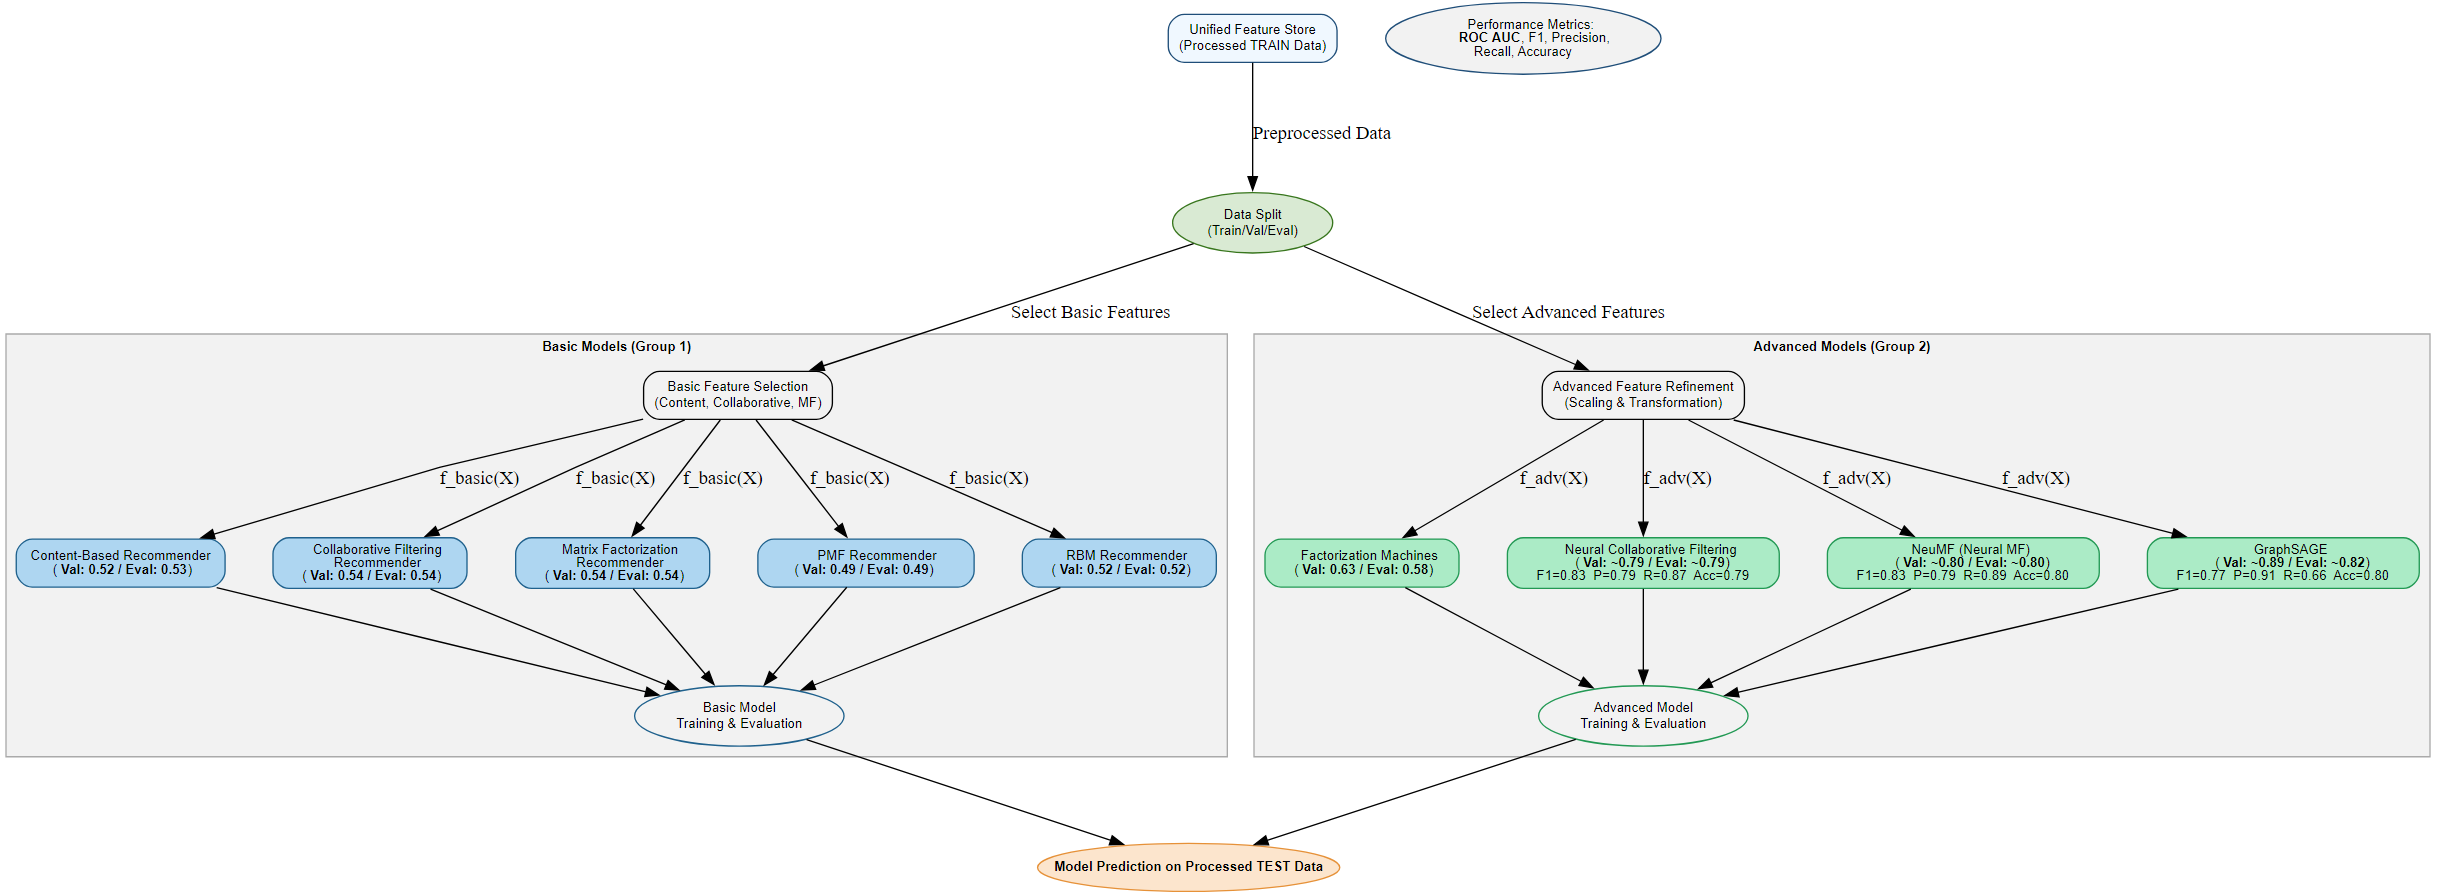

# Baseline Models & Feature Selection (Group 1)

For our initial experiments, we focus on building robust and computationally efficient baseline models. In Group 1, we employ several families of recommendation methods—including Content‑Based Filtering, Collaborative Filtering, and Matrix Factorization—along with specialized approaches such as Probabilistic Matrix Factorization (PMF) and Restricted Boltzmann Machines (RBMs). These methods are straightforward to interpret and provide a solid foundation for understanding our data and the underlying user–item interactions before we advance to more complex models.

Additionally, we incorporate a focused subset of variables from our **Unified Feature Store**, tailored for each baseline model. Below, we outline the different approaches along with the associated feature subsets.


- **Content‑Based Filtering:**  
  This method uses intrinsic item attributes to recommend similar items. It leverages variables that capture the core characteristics of each track:

  - **`media_id`**: Uniquely identifies each track and is used to retrieve item metadata.
  - **`album_id`**: Groups tracks by album.
  - **`artist_id`**: Groups tracks by artist.
  - **`genre_id`**: Provides genre information.
  - **`release_date_parsed`**: The parsed release date (originally in YYYYMMDD format) converted to a datetime object.
  - **`song_age_days`**: The computed age of the song in days, capturing recency trends.

- **Collaborative Filtering:**  
  This approach focuses on interaction signals to capture user behavior by modeling user–item interactions:

  - **`user_id`**: Uniquely identifies each user.
  - **`media_id`**: Paired with `user_id` to form interaction instances.
  - **`avg_song_listened`**: The average listening rate per track, serving as a proxy for item popularity.
  - **`skip_score`**: The fraction of times a track was skipped, providing insight into negative feedback.

- **Matrix Factorization:**  
 Matrix factorization decomposes the user–item interaction matrix into latent factors. It primarily utilizes:

  - **`user_id`** and **`media_id`**: Fundamental identifiers for users and items.

  Optionally, additional contextual variables can be included to refine the latent representations:

  - **`context_type`**: Indicates the context in which a track is played (e.g., playlist, album).
  - **`platform_name`**: Captures the operating system or device type.
  - **`binTime`**: Binned time-of-day information (e.g., “Morning” or “Evening”).
  - **`binwkd`**: Binned day type, such as “Weekday” or “Weekend.”

- **Probabilistic Matrix Factorization (PMF) Recommender:**  
PMF focuses solely on user–item interactions by learning latent factors and biases through gradient-based updates. For this model, we rely on a minimalist set of variables:

  - **`user_id`**: The user identifier.
  - **`media_id`**: The item identifier.
  - **`target`** (derived from `is_listened`): A binary label indicating whether the track was listened over 30 seconds.

- **Restricted Boltzmann Machines (RBMs) Recommender:**  
RBMs learn hidden representations from binarized input features. In our implementation, we typically use the **Content Features Group**:

  - **`media_id`:** The item identifier.
  - **`album_id`:** Groups tracks by album.
  - **`artist_id`:** Groups tracks by artist.
  - **`genre_id`:** Provides genre information.
  - **`release_date_parsed`:** The parsed release date.
  - **`song_age_days`:** The computed age of the song in days.

These features are first transformed using a binarization step (e.g., `(X > X.mean()).astype(int)`) before being fed into the RBM. The hidden features learned by the RBM are then utilized by a logistic regression classifier to predict whether a track is listened to.

---

## Sampling & Default Configurations
## Sampling & Default Configurations

Our modeling pipeline partitions the training data into three subsets—training, validation, and evaluation—using 100% of the available data (unless subsampling is needed). The typical split is approximately 70% for training, 15% for validation, and 15% for evaluation.

This partitioning can be performed in three ways:
- **Global (Time-Sorted) Split:** Data is ordered by `ts_listen` (default), which typically yields the **best ROC AUC results**.
- **User-Based Split:** Interactions are split per user based on temporal order.
- **Random Split:** Data is randomly shuffled using a fixed seed (e.g., seed 42) to ensure reproducibility.

The best AUC achieved on these splits serves as our benchmark also later for tuning and developing more advanced models that leverage richer feature sets and more computationally intensive methods.

---

## Evaluation Metric

For our Group 1 models, we use **ROC AUC** exclusively—driven by **[DSG17 competition requirement][1]** and the **imbalanced target variable**—to robustly capture classifier performance across thresholds. While we focus solely on ROC AUC here, more granular metrics will be evaluated for Group 2 models.

[1]: https://kaggle.com/competitions/dsg17-online-phase "DSG17 Online Phase, 2017. Kaggle."

---

## Module Structure & Detailed Explanation

Below is the complete module code along with detailed explanations for each section. Later, we will execute these models and discuss their outputs in depth.

### 1. Data Processing Functions

- **`ModelSpecificProcessor.GroupOne`**  
  This class encapsulates our model-specific data preprocessing steps:
  - **Feature Grouping:**  
    It defines three feature groups:
    - **Content Features:** `['media_id', 'album_id', 'artist_id', 'genre_id', 'release_date_parsed', 'song_age_days']`
    - **Collaborative Features:** `['user_id', 'media_id', 'avg_song_listened', 'skip_score']`
    - **Matrix Factorization Features:** `['user_id', 'media_id', 'context_type', 'platform_name', 'binTime', 'binwkd']`
  - **Processing and Feature Selection:**  
    The `process()` and `select_features_from_df()` methods allow us to choose the appropriate feature subset based on the modeling strategy.
  - **Data Splitting:**  
    The `prepare_train_val_eval_data()` method splits the data into training, validation, and evaluation sets using strategies such as global (time-sorted), user-based, or random splits.
  - **Class Weight Calculation:**  
    The `compute_class_weights()` function calculates balanced class weights for the binary target variable.

### 2. Recommender Models

Each recommender model inherits from the `BaseRecommender` interface and implements the `fit()` and `predict()` methods:

- **ContentBasedRecommender:**  
  Utilizes Logistic Regression on content features to capture item characteristics.
- **CollaborativeFilteringRecommender:**  
  Employs Logistic Regression on interaction data to model user behavior.
- **MatrixFactorizationRecommender:**  
  Uses Truncated SVD to reduce the dimensionality of selected features (often with context) before training a Logistic Regression classifier.
- **Restricted Boltzmann Machines (RBMs) Recommender:**  
  Learns hidden binary representations from binarized content features via a Bernoulli RBM and then classifies using Logistic Regression.
- **Probabilistic Matrix Factorization (PMF) Recommender:**  
  Implements a custom logistic matrix factorization approach with latent factors and biases that are updated through gradient descent. Predictions are generated by applying a stable sigmoid function to the computed logits.

### 3. Hyperparameter Tuning Functions

The module includes functions to fine-tune model parameters:
- **`tune_logistic_recommender()`** adjusts the `C` parameter for Logistic Regression models.
- **`tune_matrix_factorization()`** explores various numbers of SVD components to optimize the Matrix Factorization model.
- **`tune_pmf()`** searches over combinations of latent factor dimensions, learning rates, regularization strengths, and iteration counts to determine the optimal configuration for the PMF model.

### 4. Utility Functions

Utility functions facilitate model persistence and evaluation:
- **`save_model()`** and **`load_model()`** manage model serialization using pickle.
- **`evaluate_model()`** computes the ROC AUC score for a given model on a dataset.

---

This module forms the backbone of our baseline modeling efforts. In subsequent sections, we will load the processed data, execute these functions to train and tune each model, and then discuss the outputs in detail. This modular approach ensures consistency and reproducibility and also provides a clear benchmark for comparing more advanced modeling strategies in group 2.

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import BernoulliRBM
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import ParameterGrid

# --------------------- Data Processing ---------------------
class ModelSpecificProcessor:
    """
    Encapsulates various model-specific data preprocessing steps.
    """
    class GroupOne:
        def __init__(self, train_df: pd.DataFrame, test_df: pd.DataFrame):
            self.train_df = train_df
            self.test_df = test_df

        def process(self, model_type: str = "all"):
            # Define feature groups
            content_features = ['media_id', 'album_id', 'artist_id', 'genre_id',
                                'release_date_parsed', 'song_age_days']
            collaborative_features = ['user_id', 'media_id', 'avg_song_listened', 'skip_score']
            mf_features = ['user_id', 'media_id', 'context_type', 'platform_name', 'binTime', 'binwkd']

            if model_type.lower() == "content":
                selected_features = content_features
            elif model_type.lower() == "collaborative":
                selected_features = collaborative_features
            elif model_type.lower() in ["mf", "matrix_factorization"]:
                selected_features = mf_features
            elif model_type.lower() == "all":
                selected_features = list(set(content_features + collaborative_features + mf_features))
            else:
                raise ValueError("Invalid model_type. Choose 'content', 'collaborative', 'mf', or 'all'.")

            features_train = selected_features.copy()
            if 'target' in self.train_df.columns:
                features_train.append('target')

            missing_train = set(features_train) - set(self.train_df.columns)
            missing_test = set(selected_features) - set(self.test_df.columns)
            if missing_train:
                print(f"Warning: Missing in training: {missing_train}")
            if missing_test:
                print(f"Warning: Missing in test: {missing_test}")

            processed_train = self.train_df[[col for col in features_train if col in self.train_df.columns]].copy()
            processed_test = self.test_df[[col for col in selected_features if col in self.test_df.columns]].copy()
            return processed_train, processed_test

        def prepare_train_val_eval_data(self, split_strategy: str = 'global', val_ratio: float = 0.15, eval_ratio: float = 0.15):
            if 'ts_listen' not in self.train_df.columns:
                raise ValueError("Missing 'ts_listen' column.")
            df = self.train_df.copy()
            df['ts_listen'] = pd.to_datetime(df['ts_listen'])
            if split_strategy == 'global':
                df_sorted = df.sort_values('ts_listen')
                n = len(df_sorted)
                train_end = int(n * (1 - (val_ratio + eval_ratio)))
                val_end = int(n * (1 - eval_ratio))
                train_data = df_sorted.iloc[:train_end].copy()
                val_data = df_sorted.iloc[train_end:val_end].copy()
                eval_data = df_sorted.iloc[val_end:].copy()
            elif split_strategy == 'user':
                train_list, val_list, eval_list = [], [], []
                for user, group in df.groupby('user_id'):
                    group_sorted = group.sort_values('ts_listen')
                    if len(group_sorted) >= 3:
                        train_list.append(group_sorted.iloc[:-2])
                        val_list.append(group_sorted.iloc[-2:-1])
                        eval_list.append(group_sorted.iloc[-1:])
                    elif len(group_sorted) == 2:
                        train_list.append(group_sorted.iloc[:1])
                        eval_list.append(group_sorted.iloc[1:])
                    else:
                        train_list.append(group_sorted)
                train_data = pd.concat(train_list)
                val_data = pd.concat(val_list) if val_list else pd.DataFrame(columns=df.columns)
                eval_data = pd.concat(eval_list)
            elif split_strategy == 'random':
                df_shuffled = df.sample(frac=1, random_state=42)
                n = len(df_shuffled)
                val_size = int(n * val_ratio)
                eval_size = int(n * eval_ratio)
                val_data = df_shuffled.iloc[:val_size].copy()
                eval_data = df_shuffled.iloc[val_size:val_size + eval_size].copy()
                train_data = df_shuffled.iloc[val_size + eval_size:].copy()
            else:
                raise ValueError("Invalid split_strategy.")
            return train_data, val_data, eval_data

        def compute_class_weights(self, data: pd.DataFrame):
            if 'target' not in data.columns:
                raise ValueError("Data must contain 'target'.")
            classes = np.unique(data['target'])
            weights = compute_class_weight(class_weight='balanced', classes=classes, y=data['target'])
            return {cls: weight for cls, weight in zip(classes, weights)}

        def select_features_from_df(self, df: pd.DataFrame, model_type: str = "all"):
            """
            Selects appropriate features from the DataFrame based on model_type.
            Converts 'release_date_parsed' to numeric (ordinal) and factorizes remaining categorical columns.
            """
            content_features = ['media_id', 'album_id', 'artist_id', 'genre_id',
                                'release_date_parsed', 'song_age_days']
            collaborative_features = ['user_id', 'media_id', 'avg_song_listened', 'skip_score']
            mf_features = ['user_id', 'media_id', 'context_type', 'platform_name', 'binTime', 'binwkd']

            if model_type.lower() == "content":
                selected_features = content_features
            elif model_type.lower() == "collaborative":
                selected_features = collaborative_features
            elif model_type.lower() in ["mf", "matrix_factorization"]:
                selected_features = mf_features
            elif model_type.lower() == "all":
                selected_features = list(set(content_features + collaborative_features + mf_features))
            else:
                raise ValueError("Invalid model_type. Choose 'content', 'collaborative', 'mf', or 'all'.")

            features = selected_features + (['target'] if 'target' in df.columns else [])
            df_processed = df[[col for col in features if col in df.columns]].copy()

            # Convert 'release_date_parsed' to numeric (ordinal)
            if 'release_date_parsed' in df_processed.columns:
                df_processed['release_date_parsed'] = pd.to_datetime(
                    df_processed['release_date_parsed'], errors='coerce'
                ).map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)

            # Factorize remaining categorical columns
            for col in df_processed.select_dtypes(include=['object']).columns:
                df_processed[col] = pd.factorize(df_processed[col])[0]

            return df_processed

# --------------------- Recommender Models ---------------------
class BaseRecommender:
    def fit(self, X, y):
        raise NotImplementedError
    def predict(self, X):
        raise NotImplementedError

class ContentBasedRecommender(BaseRecommender):
    def __init__(self, class_weights=None):
        self.model = LogisticRegression(max_iter=1000, class_weight=class_weights)
    def fit(self, X, y):
        self.model.fit(X, y)
    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]

class CollaborativeFilteringRecommender(BaseRecommender):
    def __init__(self, class_weights=None):
        self.model = LogisticRegression(max_iter=1000, class_weight=class_weights)
    def fit(self, X, y):
        self.model.fit(X, y)
    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]

class MatrixFactorizationRecommender(BaseRecommender):
    def __init__(self, n_components=20, class_weights=None):
        self.n_components = n_components
        self.svd = None
        self.classifier = LogisticRegression(max_iter=1000, class_weight=class_weights)

    def fit(self, X, y):
        n_features = X.shape[1]
        if self.n_components > n_features:
            print(f"Adjusting n_components from {self.n_components} to {n_features} (number of features).")
            self.n_components = n_features
        self.svd = TruncatedSVD(n_components=self.n_components, random_state=42)
        X_reduced = self.svd.fit_transform(X)
        self.classifier.fit(X_reduced, y)

    def predict(self, X):
        X_reduced = self.svd.transform(X)
        return self.classifier.predict_proba(X_reduced)[:, 1]

class RBMRecommender(BaseRecommender):
    def __init__(self, n_components=100, class_weights=None):
        self.rbm = BernoulliRBM(n_components=n_components, n_iter=20, learning_rate=0.01, random_state=42)
        self.classifier = LogisticRegression(max_iter=1000, class_weight=class_weights)
    def fit(self, X, y):
        X_bin = (X > X.mean()).astype(int)
        X_transformed = self.rbm.fit_transform(X_bin)
        self.classifier.fit(X_transformed, y)
    def predict(self, X):
        X_bin = (X > X.mean()).astype(int)
        X_transformed = self.rbm.transform(X_bin)
        return self.classifier.predict_proba(X_transformed)[:, 1]

# --------------------- Advanced basic model: PMF (Logistic Matrix Factorization) ---------------------
class PMFRecommender(BaseRecommender):
    """
    A more sophisticated Logistic Matrix Factorization (PMF) recommender for binary outcomes.
    This version includes user/item biases and uses a stable sigmoid function to avoid overflow.
    """
    def __init__(self, n_factors=20, lr=0.001, reg=0.1, n_iter=50, verbose=True):
        self.n_factors = n_factors
        self.lr = lr
        self.reg = reg
        self.n_iter = n_iter
        self.verbose = verbose
        self.user_factors = None
        self.item_factors = None
        self.user_bias = None
        self.item_bias = None
        self.global_bias = None
        self.user_to_index = {}
        self.item_to_index = {}

    def stable_sigmoid(self, x):
        # Clip x to prevent overflow in exp(-x)
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        # X must contain at least 'user_id' and 'media_id'
        unique_users = X['user_id'].unique()
        unique_items = X['media_id'].unique()
        self.user_to_index = {u: i for i, u in enumerate(unique_users)}
        self.item_to_index = {i: j for j, i in enumerate(unique_items)}
        n_users = len(unique_users)
        n_items = len(unique_items)

        # Initialize latent factors
        self.user_factors = np.random.normal(scale=0.1, size=(n_users, self.n_factors))
        self.item_factors = np.random.normal(scale=0.1, size=(n_items, self.n_factors))

        # Initialize biases
        self.user_bias = np.zeros(n_users)
        self.item_bias = np.zeros(n_items)
        self.global_bias = np.mean(y)

        # Map user and item ids to indices
        user_indices = X['user_id'].map(self.user_to_index).values
        item_indices = X['media_id'].map(self.item_to_index).values
        y_array = y.values

        # Perform gradient descent updates
        for it in range(self.n_iter):
            # Compute predictions
            preds = self.global_bias + self.user_bias[user_indices] + self.item_bias[item_indices] + \
                    np.sum(self.user_factors[user_indices] * self.item_factors[item_indices], axis=1)
            preds_sigmoid = self.stable_sigmoid(preds)
            error = y_array - preds_sigmoid

            # Update global bias
            self.global_bias += self.lr * np.mean(error)

            # Update biases
            self.user_bias[user_indices] += self.lr * (error - self.reg * self.user_bias[user_indices])
            self.item_bias[item_indices] += self.lr * (error - self.reg * self.item_bias[item_indices])

            # Update latent factors
            grad_user = error[:, np.newaxis] * self.item_factors[item_indices] - self.reg * self.user_factors[user_indices]
            grad_item = error[:, np.newaxis] * self.user_factors[user_indices] - self.reg * self.item_factors[item_indices]
            np.add.at(self.user_factors, user_indices, self.lr * grad_user)
            np.add.at(self.item_factors, item_indices, self.lr * grad_item)

            if self.verbose and (it % 10 == 0 or it == self.n_iter - 1):
                loss = -np.mean(y_array * np.log(preds_sigmoid + 1e-10) + (1 - y_array) * np.log(1 - preds_sigmoid + 1e-10))
                print(f"PMF Iteration {it+1}/{self.n_iter}, loss: {loss:.4f}")

    def predict(self, X):
        preds = []
        for idx, row in X.iterrows():
            u = self.user_to_index.get(row['user_id'], None)
            i = self.item_to_index.get(row['media_id'], None)
            if u is None or i is None:
                preds.append(0.5)
            else:
                logit = self.global_bias + self.user_bias[u] + self.item_bias[i] + \
                        np.dot(self.user_factors[u], self.item_factors[i])
                preds.append(self.stable_sigmoid(logit))
        return np.array(preds)


# --------------------- Hyperparameter Tuning ---------------------
def tune_matrix_factorization(X_train, y_train, X_val, y_val, class_weights):
    # For 6 features, test n_components: 2, 4, and 6.
    param_grid = {"n_components": [2, 4, 6]}
    best_auc = -1
    best_params = None
    best_model = None

    for params in ParameterGrid(param_grid):
        print(f"Testing parameters: {params}")
        model = MatrixFactorizationRecommender(n_components=params["n_components"], class_weights=class_weights)
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        auc = roc_auc_score(y_val, y_val_pred)
        print(f"ROC AUC: {auc:.4f}")
        if auc > best_auc:
            best_auc = auc
            best_params = params
            best_model = model
    return best_model, best_params, best_auc

def tune_logistic_recommender(ModelClass, X_train, y_train, X_val, y_val, class_weights):
    """
    Tunes the Logistic Regression hyperparameter 'C' for a given recommender model.
    ModelClass should be either ContentBasedRecommender or CollaborativeFilteringRecommender.
    """
    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    best_auc = -1
    best_params = None
    best_model = None

    for params in ParameterGrid(param_grid):
        print(f"Testing parameters: {params}")
        # Instantiate the model
        model = ModelClass(class_weights=class_weights)
        # Overwrite its LogisticRegression with the tuned parameter
        model.model = LogisticRegression(max_iter=1000, C=params['C'], class_weight=class_weights)
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        auc = roc_auc_score(y_val, y_val_pred)
        print(f"ROC AUC: {auc:.4f}")
        if auc > best_auc:
            best_auc = auc
            best_params = params
            best_model = model
    return best_model, best_params, best_auc

def tune_pmf(X_train, y_train, X_val, y_val, n_factors_list=[10,20], lr_list=[0.005,0.001], reg_list=[0.01, 0.1], n_iter=50):
    best_auc = -1
    best_params = None
    best_model = None

    for n_factors in n_factors_list:
        for lr in lr_list:
            for reg in reg_list:
                print(f"Testing PMF parameters: n_factors={n_factors}, lr={lr}, reg={reg}")
                pmf_model = PMFRecommender(n_factors=n_factors, lr=lr, reg=reg, n_iter=n_iter, verbose=False)
                pmf_model.fit(X_train, y_train)
                y_val_pred = pmf_model.predict(X_val)
                auc = roc_auc_score(y_val, y_val_pred)
                print(f"ROC AUC: {auc:.4f}")
                if auc > best_auc:
                    best_auc = auc
                    best_params = {'n_factors': n_factors, 'lr': lr, 'reg': reg, 'n_iter': n_iter}
                    best_model = pmf_model
    return best_model, best_params, best_auc

# --------------------- Utility Functions ---------------------
def save_model(model, filename):
    with open(filename, "wb") as f:
        pickle.dump(model, f)

def load_model(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    return roc_auc_score(y, y_pred)

print("Basline module loaded successfully.")

Basline module loaded successfully.


## Load Data and Preprocess

We load data from our unified feature store and preprocess it for **GroupOne** models using the GroupOne processor. The data is split via a global (time-sorted) strategy into approximately **5.0M training rows** and about **1.07M rows** each for **validation** and **evaluation**. Additionally, **class weights** are computed (approximately 1.62 for class 0 and 0.72 for class 1) to address **imbalance**—ensuring a robust foundation for training and tuning our baseline models.



In [ ]:
# Load data
unified_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/processed_deezer_train.csv")
unified_test  = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/processed_deezer_test.csv")

# Instantiate the processor
processor = ModelSpecificProcessor.GroupOne(train_df=unified_train, test_df=unified_test)

# Prepare training, validation, and evaluation splits
train_data, val_data, eval_data = processor.prepare_train_val_eval_data(
    split_strategy='global', # pest performance: global
    val_ratio=0.15,
    eval_ratio=0.15
)
print("Split Dimensions:")
print("Train:", train_data.shape)
print("Validation:", val_data.shape)
print("Evaluation:", eval_data.shape)

# Compute class weights from the training data
class_weights = processor.compute_class_weights(train_data)
print("\nClass Weights:", class_weights)

Split Dimensions:
Train: (5006362, 44)
Validation: (1072792, 44)
Evaluation: (1072792, 44)

Class Weights: {0: 1.6197048765573892, 1: 0.7232731188673952}


## Train and Evaluate Models

### Content-Based Recommender

We apply logistic regression to item-specific features, tuning the `C` parameter. A best **validation ROC AUC** of **0.5237** occurs at `C = 1`, and the final **evaluation AUC** is **0.5274**. Saved as `content_model.pkl`, this model shows how intrinsic item attributes (genre, artist, album, release date) can inform recommendations.

We use a similar tuning approach for the remaining baseline models.


In [ ]:
# Tune and Train Content-Based Recommender
feature_group = "content"
proc_train = processor.select_features_from_df(train_data, model_type=feature_group)
proc_val   = processor.select_features_from_df(val_data, model_type=feature_group)
proc_eval  = processor.select_features_from_df(eval_data, model_type=feature_group)

X_train = proc_train.drop('target', axis=1)
y_train = proc_train['target']
X_val   = proc_val.drop('target', axis=1)
y_val   = proc_val['target']
X_eval  = proc_eval.drop('target', axis=1)
y_eval  = proc_eval['target']

best_content_model, best_content_params, best_content_auc = tune_logistic_recommender(
    ContentBasedRecommender, X_train, y_train, X_val, y_val, class_weights
)
print(f"Best parameters for ContentBased: {best_content_params} with ROC AUC (validation): {best_content_auc:.4f}")
auc_eval_content = evaluate_model(best_content_model, X_eval, y_eval)
print(f"ContentBased Evaluation ROC AUC: {auc_eval_content:.4f}")

# Save the best Content-Based model
save_model(best_content_model, "/content/content_model.pkl")

Testing parameters: {'C': 0.01}
ROC AUC: 0.5237
Testing parameters: {'C': 0.1}
ROC AUC: 0.5237
Testing parameters: {'C': 1}
ROC AUC: 0.5237
Testing parameters: {'C': 10}
ROC AUC: 0.5237
Testing parameters: {'C': 100}
ROC AUC: 0.5237
Best parameters for ContentBased: {'C': 1} with ROC AUC: 0.5237
ContentBased Evaluation ROC AUC: 0.5274


---
### Collaborative Filtering Recommender

We train a collaborative filtering model using logistic regression on interaction features. Tuning the `C` parameter results in a best **validation ROC AUC** of **0.5366** at `C = 0.1`, with the **evaluation AUC** reaching **0.5383**. This model, saved as `collaborative_model.pkl`, leverages key behavioral signals (user interactions, average listen rate, and skip score) to capture user preferences.


In [ ]:
# Tune and Train Collaborative Filtering Recommender
feature_group = "collaborative"
proc_train = processor.select_features_from_df(train_data, model_type=feature_group)
proc_val   = processor.select_features_from_df(val_data, model_type=feature_group)
proc_eval  = processor.select_features_from_df(eval_data, model_type=feature_group)

X_train = proc_train.drop('target', axis=1)
y_train = proc_train['target']
X_val   = proc_val.drop('target', axis=1)
y_val   = proc_val['target']
X_eval  = proc_eval.drop('target', axis=1)
y_eval  = proc_eval['target']

best_collab_model, best_collab_params, best_collab_auc = tune_logistic_recommender(
    CollaborativeFilteringRecommender, X_train, y_train, X_val, y_val, class_weights
)
print(f"Best parameters for CollaborativeFiltering: {best_collab_params} with ROC AUC (validation): {best_collab_auc:.4f}")
auc_eval_collab = evaluate_model(best_collab_model, X_eval, y_eval)
print(f"CollaborativeFiltering Evaluation ROC AUC: {auc_eval_collab:.4f}")

# Save the best Collaborative Filtering model
save_model(best_collab_model, "/content/collaborative_model.pkl")

Testing parameters: {'C': 0.01}
ROC AUC: 0.5366
Testing parameters: {'C': 0.1}
ROC AUC: 0.5366
Testing parameters: {'C': 1}
ROC AUC: 0.5366
Testing parameters: {'C': 10}
ROC AUC: 0.5366
Testing parameters: {'C': 100}
ROC AUC: 0.5366
Best parameters for CollaborativeFiltering: {'C': 0.1} with ROC AUC: 0.5366
CollaborativeFiltering Evaluation ROC AUC: 0.5383


---  
### Matrix Factorization Recommender

We use the features (user_id, media_id, context_type, platform_name, binTime, binwkd) to capture both core user–item interactions and contextual signals. After applying **Truncated SVD** for dimensionality reduction, we train a logistic regression model on the resulting latent factors. Tuning over 2, 4, and 6 components shows that **6 components** yield the best performance, with a **validation ROC AUC** of **0.5366** and an **evaluation ROC AUC** of **0.5383**. The final model is saved as `mf_model.pkl`.

In [ ]:
# Tune and Train Matrix Factorization Recommender
feature_group = "mf"
proc_train = processor.select_features_from_df(train_data, model_type=feature_group)
proc_val   = processor.select_features_from_df(val_data, model_type=feature_group)
proc_eval  = processor.select_features_from_df(eval_data, model_type=feature_group)

X_train = proc_train.drop('target', axis=1)
y_train = proc_train['target']
X_val   = proc_val.drop('target', axis=1)
y_val   = proc_val['target']
X_eval  = proc_eval.drop('target', axis=1)
y_eval  = proc_eval['target']

best_mf_model, best_mf_params, best_mf_auc = tune_matrix_factorization(X_train, y_train, X_val, y_val, class_weights)
print(f"Best parameters for MF: {best_mf_params} with ROC AUC (validation): {best_mf_auc:.4f}")
auc_eval_mf = evaluate_model(best_mf_model, X_eval, y_eval)
print(f"MatrixFactorization Evaluation ROC AUC: {auc_eval_mf:.4f}")

# Save the best MF model
save_model(best_mf_model, "/content/mf_model.pkl")


Testing parameters: {'n_components': 2}
ROC AUC: 0.5366
Testing parameters: {'n_components': 4}
ROC AUC: 0.5366
Testing parameters: {'n_components': 6}
ROC AUC: 0.5366
Best parameters for MF: {'n_components': 6} with ROC AUC: 0.5366
MatrixFactorization Evaluation ROC AUC: 0.5383


---
### PMFRecommender

Our PMFRecommender employs a logistic matrix factorization model that learns latent factors and biases via vectorized gradient descent, using only minimal features (user_id and media_id) to capture pure user–item interactions. We tune latent dimensions (10 or 20), learning rates (0.005 or 0.01), and regularization strengths (0.01 or 0.1) over 50 iterations. The **optimal setup**—**10 factors**, a **learning rate** of **0.01**, and **regularization** of **0.01**—achieves a **validation ROC AUC** of **0.4850** with an **identical evaluation AUC**. The final model is saved as `pmf_model.pkl`.




In [ ]:
# Tune and Train PMF Recommender
# For PMF, we use only the minimal features: user_id and media_id.
proc_train = processor.select_features_from_df(train_data, model_type="mf")
X_train_pmf = proc_train[['user_id', 'media_id']]
y_train_pmf = proc_train['target']

proc_val = processor.select_features_from_df(val_data, model_type="mf")
X_val_pmf = proc_val[['user_id', 'media_id']]
y_val_pmf = proc_val['target']

best_pmf_model, best_pmf_params, best_pmf_auc = tune_pmf(X_train_pmf, y_train_pmf, X_val_pmf, y_val_pmf,
                                                        n_factors_list=[10, 20], lr_list=[0.005, 0.01],
                                                        reg_list=[0.01, 0.1], n_iter=50)

print(f"Best parameters for PMF: {best_pmf_params} with ROC AUC (validation): {best_pmf_auc:.4f}")
auc_eval_pmf = evaluate_model(best_pmf_model, X_val_pmf, y_val_pmf)
print(f"PMF Evaluation ROC AUC: {auc_eval_pmf:.4f}")

# Save the best PMF model
save_model(best_pmf_model, "/content/pmf_model.pkl")

Testing PMF parameters: n_factors=10, lr=0.005, reg=0.01
ROC AUC: 0.4451
Testing PMF parameters: n_factors=10, lr=0.005, reg=0.1
ROC AUC: 0.4840
Testing PMF parameters: n_factors=10, lr=0.01, reg=0.01
ROC AUC: 0.4850
Testing PMF parameters: n_factors=10, lr=0.01, reg=0.1
ROC AUC: 0.4437
Testing PMF parameters: n_factors=20, lr=0.005, reg=0.01
ROC AUC: 0.4446
Testing PMF parameters: n_factors=20, lr=0.005, reg=0.1
ROC AUC: 0.4710
Testing PMF parameters: n_factors=20, lr=0.01, reg=0.01
ROC AUC: 0.4510
Testing PMF parameters: n_factors=20, lr=0.01, reg=0.1
ROC AUC: 0.4528
Best parameters for PMF: {'n_factors': 10, 'lr': 0.01, 'reg': 0.01, 'n_iter': 50} with ROC AUC (validation): 0.4850
PMF Evaluation ROC AUC: 0.4850


---
### Restricted Boltzmann Machine (RBM) Recommender

For the RBM model, we use the "content" feature group (i.e., media_id, album_id, artist_id, genre_id, release_date_parsed, song_age_days) to capture intrinsic item characteristics. These features are binarized and then fed into a Bernoulli RBM with 100 components, followed by logistic regression for prediction. The model achieves a **validation ROC AUC** of **0.5174** and an **evaluation ROC AUC** of **0.5187**, and is saved as `rbm_model.pkl`.

In [ ]:
# --------------------- Train RBM Recommender ---------------------
# For RBM, let's use the "content" feature group (we could use any variable here)
feature_group = "content"
proc_train = processor.select_features_from_df(train_data, model_type=feature_group)
proc_val   = processor.select_features_from_df(val_data, model_type=feature_group)
proc_eval  = processor.select_features_from_df(eval_data, model_type=feature_group)

X_train = proc_train.drop('target', axis=1)
y_train = proc_train['target']
X_val   = proc_val.drop('target', axis=1)
y_val   = proc_val['target']
X_eval  = proc_eval.drop('target', axis=1)
y_eval  = proc_eval['target']

# Instantiate and train the RBM recommender
rbm_model = RBMRecommender(n_components=100, class_weights=class_weights)
rbm_model.fit(X_train, y_train)

In [ ]:
auc_val_rbm = roc_auc_score(y_val, rbm_model.predict(X_val))
print(f"RBM Validation ROC AUC: {auc_val_rbm:.4f}")
auc_eval_rbm = roc_auc_score(y_eval, rbm_model.predict(X_eval))
print(f"RBM Evaluation ROC AUC: {auc_eval_rbm:.4f}")
save_model(rbm_model, "/content/rbm_model.pkl")

RBM Validation ROC AUC: 0.5174
RBM Evaluation ROC AUC: 0.5187


---
### Predictions for Competition

For the DSG17 Online Phase, we generate predictions by loading our saved models and processing the test data with consistent feature selection. The output is a DataFrame containing sample IDs and rounded `is_listened` probabilities, formatted as required ([DSG17 Online Phase competition][1]).

**Note:** We can sort the output by the `is_listened` probabilities to rank the recommendations, with the **highest scores** representing the **best recommendations**.

[1]: https://kaggle.com/competitions/dsg17-online-phase "DSG17 Online Phase, 2017. Kaggle."




In [ ]:
# Prediction Function
def load_and_predict(model_filename, processor, test_df, model_type="content", sample_id_col="sample_id"):
    """
    Loads a trained model from a file and generates predictions for the test dataset.

    Parameters:
      model_filename (str): Path to the saved model file.
      processor (ModelSpecificProcessor.GroupOne): The processor instance to process test data.
      test_df (pd.DataFrame): The test DataFrame.
      model_type (str): The feature set to use ("content", "collaborative", "mf", or "all").
      sample_id_col (str): Column name in test_df for the sample identifier (if available).

    Returns:
      pd.DataFrame: A DataFrame containing predictions (and sample IDs if available).
    """
    # Load the trained model from file
    model = load_model(model_filename)

    # Process the test data using the same feature selection as in training
    processed_test = processor.select_features_from_df(test_df, model_type=model_type)

    # Generate predictions using the loaded model
    predictions = model.predict(processed_test)

    # If a sample identifier column exists, include it in the output
    if sample_id_col in test_df.columns:
        output = pd.DataFrame({
            sample_id_col: test_df[sample_id_col],
            'is_listened': predictions
        })
    else:
        output = pd.DataFrame({'is_listened': predictions})

    return output

In [ ]:
# Generate Predictions on unified_test for each model

# For the Content-Based model:
content_predictions = load_and_predict("/content/content_model.pkl", processor, unified_test, model_type="content")
# Round the predictions to 2 digits
content_predictions['is_listened'] = content_predictions['is_listened'].round(1)
print("Content-based predictions (first 2 rows):")
print(content_predictions.head(2).to_csv(index=False))
print("\n")

# For the Collaborative Filtering model:
collab_predictions = load_and_predict("/content/collaborative_model.pkl", processor, unified_test, model_type="collaborative")
collab_predictions['is_listened'] = collab_predictions['is_listened'].round(1)
print("Collaborative-based predictions (first 2 rows):")
print(collab_predictions.head(2).to_csv(index=False))
print("\n")

# For the Matrix Factorization model:
mf_predictions = load_and_predict("/content/mf_model.pkl", processor, unified_test, model_type="mf")
mf_predictions['is_listened'] = mf_predictions['is_listened'].round(1)
print("Matrix Factorization predictions (first 2 rows):")
print(mf_predictions.head(2).to_csv(index=False))

# For the PMF model:
pmf_test = processor.select_features_from_df(unified_test, model_type="mf")[['user_id', 'media_id']]
pmf_predictions = load_and_predict("/content/pmf_model.pkl", processor, pmf_test, model_type="mf")
pmf_predictions['is_listened'] = pmf_predictions['is_listened'].round(2)
print("PMF predictions (first 2 rows):")
print(pmf_predictions.head(2).to_csv(index=False))

# For the RBM mdoel:
rbm_predictions = load_and_predict("/content/rbm_model.pkl", processor, unified_test, model_type=feature_group)
rbm_predictions['is_listened'] = rbm_predictions['is_listened'].round(2)
print("RBM predictions (first 2 rows):")
print(rbm_predictions.head(2).to_csv(index=False))

Content-based predictions (first 2 rows):
sample_id,is_listened
0,0.5
1,0.5



Collaborative-based predictions (first 2 rows):
sample_id,is_listened
0,0.4
1,0.5



Matrix Factorization predictions (first 2 rows):
sample_id,is_listened
0,0.4
1,0.5

PMF predictions (first 2 rows):
is_listened
0.5
1.0

RBM predictions (first 2 rows):
sample_id,is_listened
0,0.48
1,0.48



---
## Summary of Baseline Models
Below is a concise summary of each baseline model’s performance and key hyperparameters. **Collaborative Filtering** and **Matrix Factorization** tie for the highest **evaluation AUC (0.5383)**, while **PMF** lags at **0.4850**—highlighting the strengths of interaction-focused methods in our current setup.

| **Model**                               | **Validation AUC** | **Evaluation AUC** | **Key Hyperparameters**                  |
|:----------------------------------------|:------------------:|:------------------:|:-----------------------------------------|
| Content‑Based Recommender              | 0.5237            | 0.5274            | `C=1` (Logistic Regression)              |
| Collaborative Filtering Recommender    | 0.5366            | 0.5383            | `C=0.1` (Logistic Regression)            |
| Matrix Factorization Recommender       | 0.5366            | 0.5383            | `n_components=6` (Truncated SVD + LR)    |
| PMF Recommender                        | 0.4850            | 0.4850            | `n_factors=10, lr=0.01, reg=0.01` (PMF)  |
| RBM Recommender                        | 0.5174            | 0.5187            | `n_components=100` (RBM + LR)            |



---
# Advanced Models & Feature Selection (Group 2)

In Group 2, we extend our framework to more complex models that leverage a rich, advanced feature set from our **Unified Feature Store**. These models not only use the basic interaction and content features but also incorporate contextual, temporal, and behavioral variables. Below, we outline the different approaches along with the associated feature subsets.

- **Factorization Machine (FM) Recommender:**  
  This method employs fastFM's FMClassification to model pairwise feature interactions on an extensive feature set. The FM recommender converts the data into a sparse matrix representation and tunes hyperparameters such as rank, iteration count, and regularization terms to optimize performance.  
  **Features included in the FM model:**
  - **Identifiers:**  
    `media_id`, `album_id`, `artist_id`, `genre_id`, `user_id`
  - **Contextual Features:**  
    `context_type`, `listen_type`, `platform_name`, `platform_family`
  - **Temporal Features:**  
    `binTime`, `binwkd`, `binRYear`
  - **Behavioral & Derived Features:**  
    `md_mf_group`, `user_top_genre`, `hour`, `weekday`, `day`, `week`, `month`, `year`, `release_date_parsed`, `song_age_days`, `avg_song_listened`, `skip_score`, `behavior_index`

- **Neural Collaborative Filtering (NCF) Models:**  
  This approach uses deep neural networks to capture complex interactions between users and items. By utilizing embedding layers for users and items followed by fully connected layers, the NCF models learn latent representations.  
  **Features utilized in the NCF models:**
  - **Core Interaction Features:**  
    `user_id` and `media_id`
  - **Optional Side Information:**  
    Additional contextual or behavioral features may be incorporated if needed, though the focus is primarily on learning from the user–item interaction data via embeddings.

- **Neural Matrix Factorization (NeuMF):**  
  NeuMF combines two complementary branches: a Generalized Matrix Factorization (GMF) branch to capture linear interactions and a Multi-Layer Perceptron (MLP) branch to model non-linear interactions. This dual-branch architecture should enhance predictive performance by integrating the strengths of both approaches.  
  **Feature subsets for NeuMF include:**
  - **Core Identifiers:**  
    `user_id` and `media_id`
  - **Latent Representations:**  
    - The **GMF branch** leverages element-wise multiplication of user and item embeddings to model linear interactions.
    - The **MLP branch** learns higher-order, non-linear interactions through concatenated embeddings and deep neural layers.
  - **Optional Integration of Side Information:**  
    Although the primary inputs are the user and item IDs, NeuMF can be extended to include additional advanced features if required.

- **Graph Sample and Aggregate (GraphSAGE) Recommender:**  
  This approach frames recommendation as a **graph learning problem**. Users and items are treated as nodes in a bipartite graph, with edges representing positive interactions. By applying **GraphSAGE** (via PyTorch Geometric’s `SAGEConv`), we iteratively sample and aggregate information from each node’s neighbors to learn robust node embeddings.  
  **Features & Construction for GraphSAGE:**
  - **Core Node Identifiers:**  
    `user_id` and `media_id` are mapped to contiguous integer IDs.  
  - **Edges:**  
    Constructed from positive interactions (`target = 1`), optionally including advanced features if available.  
  - **Embedding & Message Passing:**  
    Multiple SAGEConv layers aggregate neighborhood embeddings, refining each node’s representation.  
  - **Prediction:**  
  A dot product between user and item embeddings, followed by a sigmoid activation, produces the final interaction probability.


This advanced modeling framework allows us to capture richer and more nuanced relationships in the data, setting the stage for improved recommendation performance compared to the baseline models.

---

## Sampling & Default Configurations

Consistent with our baseline models, the advanced pipeline uses flexible sampling to split data into training (70%), validation (15%), and evaluation (15%) sets. By default, the full dataset is used (unless subsampling is needed), and the **global split strategy** is employed because it yielded the best ROC AUC results in the baseline models from Group 1.However for **NCF** and **NeuMF** we opted for a **random split** to create a more diverse training set that better suits deep architectures. This random split achieved higher ROC AUC, although limited tuning and potential overfitting (due to computational constraints) may also play a role.

---

## Evaluation Metric

For our advanced models, we use a comprehensive set of metrics. While **ROC AUC** is the primary indicator of the competition, we also evaluate for the best performing models **precision**, **recall**, **F1 score**, and **confusion matrices** to understand model behavior, especially with imbalanced targets. Additionally, **ROC** and **Precision-Recall curves** aid in performance diagnosis. These metrics collectively guide model tuning and selection.

---

## Module Structure & Detailed Explanation

Below is an overview of the advanced module code along with detailed explanations for each section. Later, we will execute these models and discuss their outputs in depth.

1. **Data Processing Functions**
   - **AdvancedPreprocessor:**  
     This class is dedicated to preparing data for advanced models. It includes:
     - **Data Splitting:**  
       The `prepare_train_val_eval_data()` method splits the dataset into training, validation, and evaluation sets using different strategies:
       - **Global (Time-Sorted) Split:** Orders data by `ts_listen` (default, as it produced the best ROC AUC in Group 1, used in FM and GraphSAGE).
       - **User-Based Split:** Splits interactions per user based on their temporal order.
       - **Random Split:** Shuffles the data using a fixed seed (e.g., seed 42) to ensure reproducibility (used in NCF and NeuMF).
     - **Class Weight Calculation:**  
       The `compute_class_weights()` function computes balanced class weights for the binary target variable.
     - **Feature Selection & Scaling:**  
       The `select_features()` method selects a rich set of advanced features (e.g., identifiers, contextual, temporal, and behavioral features), converts date features (like `release_date_parsed`) to ordinal numbers, factorizes categorical variables, fills missing values, and scales non-target features to the [0,1] range.
    - **Additional Preprocessing for NCF, NeuMF, and GraphSAGE:**  
      NCF and NeuMF use the `further_process_neural_cf` function to remap `user_id` and `media_id` to contiguous integers and select key features, while GraphSAGE employs a dedicated `GraphDataProcessor` to map IDs, build edge indices from positive interactions, and prepare the graph structure.


2. **Recommender Models**
   - **[Factorization Machine Recommender][1]:**  
     Inherits from the `BaseRecommender` interface and leverages fastFM’s `FMClassification` to model pairwise feature interactions. Key steps include:
     - Converting the feature matrix into a sparse representation using `csr_matrix`.
     - Configuring hyperparameters such as rank, iteration count, and L2 regularization strengths.
   - **[Neural Collaborative Filtering][2] (NCF) Model:**  
     Built using TensorFlow and Keras, this model:
     - Uses embedding layers to learn latent representations for `user_id` and `media_id`.
     - Incorporates fully connected (dense) layers with dropout and L2 regularization.
     - Utilizes an exponential learning rate decay schedule, with tunable hyperparameters (embedding dimensions, number of units, dropout rate, etc.).
   - **[Neural Matrix Factorization][2] (NeuMF) Model:**  
     Combines two complementary branches to capture both linear and non-linear interactions:
     - **GMF Branch:** Uses element-wise multiplication of user and item embeddings to capture linear interactions.
     - **MLP Branch:** Processes concatenated embeddings through multiple dense layers with batch normalization and dropout to model non-linear relationships.
     - The outputs from both branches are concatenated and fed into a final prediction layer.
  - **[Graph Sample and Aggregate][3] (GraphSAGE) Recommender ([Study Github][4], [PyG][5])**  
     Frames recommendation as a graph learning problem by treating users and items as nodes in a bipartite graph. It uses PyTorch Geometric’s `SAGEConv` layers to iteratively aggregate neighborhood information and learn robust node embeddings. The edge index is built from positive interactions (with item indices shifted by the number of users), and predictions are generated by taking the dot product of user and item embeddings followed by a sigmoid activation.

[1]: https://doi.org/10.1109/MC.2009.263 "Y. Koren, R. Bell and C. Volinsky, 'Matrix Factorization Techniques for Recommender Systems,' in Computer, vol. 42, no. 8, pp. 30-37, Aug. 2009, doi: 10.1109/MC.2009.263."
[2]: https://arxiv.org/abs/1708.05031 "He, X., Liao, L., Zhang, H., Nie, L., Hu, X., & Chua, T.-S. (2017). Neural Collaborative Filtering."
[3]: https://arxiv.org/abs/1706.02216 "Hamilton, W., Ying, Z., & Leskovec, J. (2017). Inductive Representation Learning on Large Graphs (GraphSAGE)."
[4]: https://github.com/williamleif/GraphSAGE "GraphSAGE by William LeiF (GitHub)"
[5]: https://github.com/pyg-team/pytorch_geometric "PyTorch Geometric by the PyG Team (GitHub)"

---

3. **Hyperparameter Tuning Functions**
   - **tune_fm():**  
     This function uses scikit-learn's `ParameterGrid` to perform grid search over hyperparameters for the FM recommender. It tests various combinations (e.g., rank, number of iterations, and L2 regularization strengths) and selects the best configuration based on ROC AUC on the validation set.
   - **Hyperparameter Tuning for Deep Models (NCF/NeuMF):**  
     Hyperparameter tuning for the neural models is implemented using Keras Tuner. The tuner searches over parameters such as:
     - **Embedding Dimensions:** The size of latent representations.
     - **Dense Layer Architecture:** Number and size of dense layers.
     - **Dropout Rates and L2 Regularization:** To mitigate overfitting.
     - **Learning Rate:** With adjustable rates and decay schedules.
     The tuner evaluates each configuration based on validation performance (e.g., ROC AUC) and selects the optimal settings for both NCF and NeuMF.

---

4. **Utility Functions**
   - **Model Persistence:**  
     Functions such as `save_model()` and `load_model()` manage model serialization using pickle.
   - **Evaluation Functions:**  
     The `evaluate_model()` function computes performance metrics (e.g., ROC AUC) for a given model and dataset.
   - **Visualization Functions:**  
     Plotting functions (NCF: `plot_evaluation_metrics_ncf`, NeuMF: `plot_evaluation_metrics_neumf`, GraphSAGE: `plot_evaluation_metrics`) generate visual summaries (loss curves, ROC curves, confusion matrices, and Precision-Recall curves) to aid in performance diagnosis and model comparison.

---

This module underpins our advanced modeling efforts. In later sections, we load processed data, train and tune each model, analyze and compare the outputs of these advanced models.





In [ ]:
!pip install fastFM
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastFM: filename=fastFM-0.2.10-cp310-cp310-linux_x86_64.whl size=591780 sha256=76ae766a73257a38b26937c52ad48b7162200f12c002fd02656d6af99a33d22c
  Stored in directory: /root/.cache/pip/wheels/93/92/52/2da7997fcb7a7ce9042ff3b33836ef0c2fd47aa95382d7a113
Successfully built fastFM
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import ParameterGrid, train_test_split
from scipy.sparse import csr_matrix
from fastFM import sgd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout, BatchNormalization, Activation, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------- Advanced Preprocessor ---------------------
class AdvancedPreprocessor:
    """
    A preprocessor dedicated to advanced models that leverages a rich feature set.
    This class prepares data from the full feature store for training advanced models.
    """
    def __init__(self, train_df: pd.DataFrame, test_df: pd.DataFrame):
        self.train_df = train_df
        self.test_df = test_df

    def prepare_train_val_eval_data(self, split_strategy: str = 'global',
                                      val_ratio: float = 0.15, eval_ratio: float = 0.15):
        if 'ts_listen' not in self.train_df.columns:
            raise ValueError("Missing 'ts_listen' column.")
        df = self.train_df.copy()
        df['ts_listen'] = pd.to_datetime(df['ts_listen'])
        if split_strategy == 'global':
            df_sorted = df.sort_values('ts_listen')
            n = len(df_sorted)
            train_end = int(n * (1 - (val_ratio + eval_ratio)))
            val_end = int(n * (1 - eval_ratio))
            train_data = df_sorted.iloc[:train_end].copy()
            val_data = df_sorted.iloc[train_end:val_end].copy()
            eval_data = df_sorted.iloc[val_end:].copy()
        elif split_strategy == 'user':
            train_list, val_list, eval_list = [], [], []
            for user, group in df.groupby('user_id'):
                group_sorted = group.sort_values('ts_listen')
                if len(group_sorted) >= 3:
                    train_list.append(group_sorted.iloc[:-2])
                    val_list.append(group_sorted.iloc[-2:-1])
                    eval_list.append(group_sorted.iloc[-1:])
                elif len(group_sorted) == 2:
                    train_list.append(group_sorted.iloc[:1])
                    eval_list.append(group_sorted.iloc[1:])
                else:
                    train_list.append(group_sorted)
            train_data = pd.concat(train_list)
            val_data = pd.concat(val_list) if val_list else pd.DataFrame(columns=df.columns)
            eval_data = pd.concat(eval_list)
        elif split_strategy == 'random':
            df_shuffled = df.sample(frac=1, random_state=42)
            n = len(df_shuffled)
            val_size = int(n * val_ratio)
            eval_size = int(n * eval_ratio)
            val_data = df_shuffled.iloc[:val_size].copy()
            eval_data = df_shuffled.iloc[val_size:val_size + eval_size].copy()
            train_data = df_shuffled.iloc[val_size + eval_size:].copy()
        else:
            raise ValueError("Invalid split_strategy.")
        return train_data, val_data, eval_data

    def compute_class_weights(self, data: pd.DataFrame):
        if 'target' not in data.columns:
            raise ValueError("Data must contain 'target'.")
        classes = np.unique(data['target'])
        weights = compute_class_weight(class_weight='balanced', classes=classes, y=data['target'])
        return {cls: weight for cls, weight in zip(classes, weights)}

    def select_features(self, df: pd.DataFrame):
        """
        Selects a rich feature set from the DataFrame.
        This 'advanced' feature set (fm_all) includes a wide range of variables from the feature store.
        After selection and conversion, all features (except target) are scaled to [0,1].
        """
        advanced_features = [
            'media_id', 'album_id', 'artist_id', 'genre_id', 'user_id',
            'context_type', 'listen_type', 'platform_name', 'platform_family',
            'binTime', 'binwkd', 'binRYear', 'md_mf_group', 'user_top_genre',
            'hour', 'weekday', 'day', 'week', 'month', 'year',
            'release_date_parsed', 'song_age_days', 'avg_song_listened',
            'skip_score', 'behavior_index'
        ]
        selected_features = [feat for feat in advanced_features if feat in df.columns]
        if 'target' in df.columns:
            selected_features.append('target')
        df_adv = df[selected_features].copy()

        # Convert 'release_date_parsed' to numeric (ordinal)
        if 'release_date_parsed' in df_adv.columns:
            df_adv['release_date_parsed'] = pd.to_datetime(df_adv['release_date_parsed'], errors='coerce') \
                                             .map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
        # Factorize any object columns
        for col in df_adv.select_dtypes(include=['object']).columns:
            df_adv[col] = pd.factorize(df_adv[col])[0]

        # Fill any remaining NaN values with 0
        df_adv = df_adv.fillna(0)

        # Separate features and scale only the features (excluding target)
        if 'target' in df_adv.columns:
            target = df_adv['target']
            features = df_adv.drop('target', axis=1)
            scaler = MinMaxScaler()
            features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
            df_adv = pd.concat([features_scaled, target.reset_index(drop=True)], axis=1)
        else:
            scaler = MinMaxScaler()
            df_adv = pd.DataFrame(scaler.fit_transform(df_adv), columns=df_adv.columns)

        return df_adv

# --------------------- Advanced Model: Factorization Machine Recommender ---------------------
class BaseRecommender:
    def fit(self, X, y):
        raise NotImplementedError
    def predict(self, X):
        raise NotImplementedError

class FactorizationMachineRecommender(BaseRecommender):
    """
    A Factorization Machine (FM) recommender for binary outcomes.
    This model uses fastFM's FMClassification to model pairwise feature interactions
    on a rich, advanced feature set.
    """
    def __init__(self, rank=20, n_iter=100, l2_reg_w=0.1, l2_reg_V=0.1):
        self.rank = rank
        self.n_iter = n_iter
        self.l2_reg_w = l2_reg_w
        self.l2_reg_V = l2_reg_V
        self.model = sgd.FMClassification(
            n_iter=self.n_iter,
            rank=self.rank,
            l2_reg_w=self.l2_reg_w,
            l2_reg_V=self.l2_reg_V,
            random_state=42
        )

    def fit(self, X, y):
        X_sparse = csr_matrix(X.values)
        self.model.fit(X_sparse, y)

    def predict(self, X):
        X_sparse = csr_matrix(X.values)
        probas = self.model.predict_proba(X_sparse)
        # fastFM may return a 1D array or a 2D array; handle both:
        if probas.ndim == 1:
            return probas
        else:
            return probas[:, 1]

# --------------------- Hyperparameter Tuning for FM ---------------------
def tune_fm(X_train, y_train, X_val, y_val, param_grid):
    """
    Tune the Factorization Machine recommender using grid search over the provided parameter grid.
    """
    best_auc = -1
    best_params = None
    best_model = None

    for params in ParameterGrid(param_grid):
        print(f"Testing parameters: {params}")
        fm_model = FactorizationMachineRecommender(
            rank=params['rank'],
            n_iter=params['n_iter'],
            l2_reg_w=params['l2_reg_w'],
            l2_reg_V=params['l2_reg_V']
        )
        fm_model.fit(X_train, y_train)
        preds = fm_model.predict(X_val)
        auc = roc_auc_score(y_val.replace({0: 0, 1: 1}), preds)
        print(f"ROC AUC: {auc:.4f}")
        if auc > best_auc:
            best_auc = auc
            best_params = params
            best_model = fm_model
    return best_model, best_params, best_auc

# --------------------- Utility Functions ---------------------
def save_model(model, filename):
    with open(filename, "wb") as f:
        pickle.dump(model, f)

def load_model(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    return roc_auc_score(y, y_pred)

def load_and_predict(model_filename, preprocessor, test_df, sample_id_col="sample_id"):
    """
    Loads a trained model from a file and generates predictions for the test dataset.
    The preprocessor is an instance of AdvancedPreprocessor.
    """
    model = load_model(model_filename)
    processed_test = preprocessor.select_features(test_df)
    predictions = model.predict(processed_test)
    if sample_id_col in test_df.columns:
        output = pd.DataFrame({sample_id_col: test_df[sample_id_col], 'is_listened': predictions})
    else:
        output = pd.DataFrame({'is_listened': predictions})
    return output

# --------------------- Neural Collaborative Filtering (NCF) ---------------------
def further_process_neural_cf(df: pd.DataFrame, sample_frac: float = 0.2) -> pd.DataFrame:
    """
    Further process the unified dataset for Neural Collaborative Filtering.
    - Optionally sample a fraction of the data.
    - Map user_id and media_id to contiguous integers.
    - Select key features: user_id, media_id, target and optionally behavior_index.

    Parameters:
      df (pd.DataFrame): The unified, preprocessed training DataFrame.
      sample_frac (float): Fraction of the data to sample (default: 0.2).

    Returns:
      pd.DataFrame: A processed DataFrame ready for Neural CF models.
    """
    df_proc = df.copy()
    if sample_frac < 1.0:
        df_proc = df_proc.sample(frac=sample_frac, random_state=42).reset_index(drop=True)
    user_mapping = {old: new for new, old in enumerate(sorted(df_proc['user_id'].unique()))}
    media_mapping = {old: new for new, old in enumerate(sorted(df_proc['media_id'].unique()))}
    df_proc['user_id'] = df_proc['user_id'].map(user_mapping)
    df_proc['media_id'] = df_proc['media_id'].map(media_mapping)
    selected_columns = ['user_id', 'media_id', 'target']
    if 'behavior_index' in df_proc.columns:
        selected_columns.append('behavior_index')
    processed_df = df_proc[selected_columns].reset_index(drop=True)
    return processed_df

def build_neural_cf_model_with_fixed(hp: kt.HyperParameters, num_users: int, num_items: int) -> Model:
    """
    Build a Neural Collaborative Filtering model using Keras.
    Tunable hyperparameters include:
      - embedding_dim: Dimension for embeddings.
      - fc_units: Number of units in the first dense layer.
      - fc2_units: Number of units in the second dense layer.
      - dropout_rate: Dropout rate.
      - l2_reg: L2 regularization coefficient.
      - learning_rate: Initial learning rate.

    Adjustments made to reduce overfitting:
      - Dropout rate (default 0.5).
      - L2 regularization.
      - Network complexity (fewer units in dense layers).
    """
    # Input layers.
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')

    # Tunable embedding dimension.
    embedding_dim = hp.Int('embedding_dim', min_value=8, max_value=32, step=8, default=16)

    # Embedding layers with Glorot uniform initialization.
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim,
                               embeddings_initializer='glorot_uniform',
                               name='user_embedding')(user_input)
    item_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim,
                               embeddings_initializer='glorot_uniform',
                               name='item_embedding')(item_input)

    # Flatten the embeddings.
    user_vec = Flatten(name='user_flatten')(user_embedding)
    item_vec = Flatten(name='item_flatten')(item_embedding)

    # Concatenate user and item vectors.
    concat = Concatenate(name='concatenate')([user_vec, item_vec])

    # L2 regularization.
    l2_reg = hp.Float('l2_reg', min_value=1e-3, max_value=1e-1, sampling='log', default=1e-2)

    # Fully-connected layer 1.
    fc_units = hp.Int('fc_units', min_value=8, max_value=32, step=8, default=16)
    fc = Dense(fc_units, kernel_initializer='glorot_uniform',
               kernel_regularizer=regularizers.l2(l2_reg),
               name='fc1')(concat)
    fc = BatchNormalization(name='bn1')(fc)
    fc = Activation('relu', name='relu1')(fc)
    dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.1, default=0.4)
    fc = Dropout(dropout_rate, name='dropout1')(fc)

    # Fully-connected layer 2.
    fc2_units = hp.Int('fc2_units', min_value=8, max_value=32, step=8, default=16)
    fc = Dense(fc2_units, kernel_initializer='glorot_uniform',
               kernel_regularizer=regularizers.l2(l2_reg),
               name='fc2')(fc)
    fc = BatchNormalization(name='bn2')(fc)
    fc = Activation('relu', name='relu2')(fc)
    fc = Dropout(dropout_rate, name='dropout2')(fc)

    # Output layer with sigmoid activation.
    output = Dense(1, activation='sigmoid', name='output')(fc)

    # Learning rate schedule with exponential decay.
    initial_lr = hp.Choice('learning_rate', values=[1e-3, 1e-4], default=1e-4)
    lr_schedule = ExponentialDecay(initial_learning_rate=initial_lr,
                                   decay_steps=10000,
                                   decay_rate=0.9,
                                   staircase=True)
    optimizer = Adam(learning_rate=lr_schedule)

    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    return model


# --------------------- NeuMF model: With separate GMF and MLP branches (Xiangnan He et al 2017) and a some hyperparameter tuneing ---------------------
def build_neumf_model_with_hp(hp: kt.HyperParameters, num_users: int, num_items: int) -> Model:
    """
    Build a Neural Matrix Factorization (NeuMF) model with hyperparameters to tune the architecture.

    Tunable hyperparameters include:
      - gmf_embedding_dim: Dimension for the GMF branch embeddings.
      - mlp_embedding_dim: Dimension for the MLP branch embeddings.
      - num_mlp_layers: Number of dense layers in the MLP branch.
      - mlp_units_i: Number of units in each MLP dense layer.
      - mlp_reg_i: L2 regularization factor for each MLP dense layer.
      - dropout_rate: Dropout rate applied after each MLP Dense layer.
      - learning_rate: Initial learning rate.

    Parameters:
      - num_users: Number of unique users.
      - num_items: Number of unique items.
      - hp: Keras Tuner HyperParameters object.

    Returns:
      - A compiled Keras Model.
    """
    # Input layers.
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')

    # Tunable hyperparameters for embeddings.
    gmf_embedding_dim = hp.Int('gmf_embedding_dim', min_value=8, max_value=32, step=8, default=16)
    mlp_embedding_dim = hp.Int('mlp_embedding_dim', min_value=8, max_value=32, step=8, default=16)

    # ----------------- GMF Branch -----------------
    gmf_user_embedding = Embedding(input_dim=num_users, output_dim=gmf_embedding_dim,
                                   embeddings_initializer='he_normal',
                                   name='gmf_user_embedding')(user_input)
    gmf_item_embedding = Embedding(input_dim=num_items, output_dim=gmf_embedding_dim,
                                   embeddings_initializer='he_normal',
                                   name='gmf_item_embedding')(item_input)
    gmf_user_flat = Flatten(name='gmf_user_flat')(gmf_user_embedding)
    gmf_item_flat = Flatten(name='gmf_item_flat')(gmf_item_embedding)
    gmf_vector = Multiply(name='gmf_multiply')([gmf_user_flat, gmf_item_flat])

    # ----------------- MLP Branch -----------------
    mlp_user_embedding = Embedding(input_dim=num_users, output_dim=mlp_embedding_dim,
                                   embeddings_initializer='he_normal',
                                   name='mlp_user_embedding')(user_input)
    mlp_item_embedding = Embedding(input_dim=num_items, output_dim=mlp_embedding_dim,
                                   embeddings_initializer='he_normal',
                                   name='mlp_item_embedding')(item_input)
    mlp_user_flat = Flatten(name='mlp_user_flat')(mlp_user_embedding)
    mlp_item_flat = Flatten(name='mlp_item_flat')(mlp_item_embedding)
    mlp_vector = Concatenate(name='mlp_concat')([mlp_user_flat, mlp_item_flat])

    # Tunable hyperparameters for the MLP dense layers.
    num_mlp_layers = hp.Int('num_mlp_layers', min_value=1, max_value=4, default=2)
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1, default=0.2)

    x = mlp_vector
    for i in range(num_mlp_layers):
        # Number of units in this layer.
        units = hp.Int(f'mlp_units_{i}', min_value=16, max_value=128, step=16, default=64)
        # L2 regularization factor for this layer.
        reg = hp.Float(f'mlp_reg_{i}', min_value=1e-5, max_value=1e-2, sampling='log', default=1e-3)
        x = Dense(units, activation='relu',
                  kernel_regularizer=regularizers.l2(reg),
                  name=f'mlp_dense_{i}')(x)
        # Optionally, add BatchNormalization here:
        x = BatchNormalization(name=f'bn_{i}')(x)
        x = Dropout(dropout_rate, name=f'mlp_dropout_{i}')(x)
    mlp_output = x

    # ----------------- Concatenate GMF and MLP branches -----------------
    neumf_vector = Concatenate(name='neumf_concat')([gmf_vector, mlp_output])

    # Final prediction layer.
    prediction = Dense(1, activation='sigmoid', name='prediction')(neumf_vector)

    # Learning rate hyperparameter.
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4], default=1e-4)
    optimizer = Adam(learning_rate=learning_rate)

    model = Model(inputs=[user_input, item_input], outputs=prediction)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

def plot_evaluation_metrics_ncf(history, y_eval, y_pred_probs, y_pred_classes, baseline_auc):
    """
    Create a 2x3 grid of evaluation plots including:
      - Plot A: Training and validation loss over epochs.
      - Plot B: Training and validation AUC over epochs with a horizontal line for the baseline AUC.
      - Plot C: Confusion Matrix.
      - Plot D: ROC Curve.
      - Plot E: Precision-Recall Curve.
      - Plot F: A placeholder for additional plots or a metrics summary.

    Parameters:
      history : Keras History object from training.
      y_eval : True labels for the evaluation set.
      y_pred_probs : Continuous probability predictions from the model.
      y_pred_classes : Binary class predictions (obtained via a threshold, e.g., 0.5).
      baseline_auc : The baseline AUC (typically 0.5 for a random classifier).
    """
    # Compute additional metrics for the evaluation set
    roc_fpr, roc_tpr, _ = roc_curve(y_eval, y_pred_probs)
    roc_auc_val = auc(roc_fpr, roc_tpr)
    precision_vals, recall_vals, _ = precision_recall_curve(y_eval, y_pred_probs)
    f1 = f1_score(y_eval, y_pred_classes)
    report = classification_report(y_eval, y_pred_classes, output_dict=True)
    eval_loss, eval_accuracy = model.evaluate([X_user_eval, X_item_eval], y_eval, verbose=2)

    # Create subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    fig.suptitle("NCF Model Evaluation Metrics", fontsize=18)

    # Plot A: Loss over epochs (training & validation)
    axes[0, 0].plot(history.history['loss'], label='Train Loss', marker='o', color='blue')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', marker='o', color='orange')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Loss Over Epochs (Train/Val)')
    axes[0, 0].legend()

    # Plot B: AUC over epochs (training & validation)
    axes[0, 1].plot(history.history['auc'], label='Train AUC', marker='o', color='blue')
    axes[0, 1].plot(history.history['val_auc'], label='Validation AUC', marker='o', color='orange')
    axes[0, 1].axhline(y=baseline_auc, color='red', linestyle='--',
                        label=f'Basline (AUC = {baseline_auc:.2f})')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('ROC AUC')
    axes[0, 1].set_title('ROC AUC (Train/Val)')
    axes[0, 1].legend()

    # Plot C: Confusion Matrix for evaluation set
    cm = confusion_matrix(y_eval, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 2])
    axes[0, 2].set_xlabel('Predicted Label')
    axes[0, 2].set_ylabel('True Label')
    axes[0, 2].set_title('Confusion Matrix (Eval)')

    # Plot D: ROC Curve for evaluation set
    axes[1, 0].plot(roc_fpr, roc_tpr, color='darkorange', lw=2,
                    label=f'ROC (AUC = {roc_auc_val:.2f})')
    axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].set_title('ROC Curve (Eval)')
    axes[1, 0].legend(loc='lower right')

    # Plot E: Precision-Recall Curve for evaluation set
    axes[1, 1].plot(recall_vals, precision_vals, color='green', lw=2)
    axes[1, 1].set_xlabel('Recall')
    axes[1, 1].set_ylabel('Precision')
    axes[1, 1].set_title('Precision-Recall Curve')

    # Plot F: Metrics summary placeholder
    summary_text = (f"Evaluation metrics (Eval):\n"
                    f"F1 Score: {f1:.2f}\n"
                    f"Precision (pos): {report['1']['precision']:.2f}\n"
                    f"Recall (pos): {report['1']['recall']:.2f}\n"
                    f"Accuracy: {eval_accuracy:.2f}")
    axes[1, 2].text(0.5, 0.5, summary_text,
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=12, color='gray', transform=axes[1, 2].transAxes)
    axes[1, 2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_evaluation_metrics_neumf(history, y_eval, y_pred_probs, y_pred_classes, baseline_accuracy):
    """
    Create a 2x3 grid of evaluation plots including:
      - Training and validation loss over epochs.
      - Training and validation accuracy over epochs with a horizontal line for the baseline accuracy.
      - Confusion Matrix.
      - ROC Curve.
      - Precision-Recall Curve.
      - A placeholder for additional plots.

    Parameters:
      history : Keras History object from training.
      y_eval : True labels for the evaluation set.
      y_pred_probs : Continuous probability predictions from the model.
      y_pred_classes : Binary class predictions (obtained via a threshold, e.g., 0.5).
      baseline_accuracy : The No Information Rate (baseline accuracy).
    """
    # Compute additional metrics for Evaluation Set
    roc_fpr, roc_tpr, _ = roc_curve(y_eval, y_pred_probs)
    roc_auc_val = auc(roc_fpr, roc_tpr)
    precision, recall, _ = precision_recall_curve(y_eval, y_pred_probs)
    f1 = f1_score(y_eval, y_pred_classes)
    report = classification_report(y_eval, y_pred_classes, output_dict=True)
    eval_loss, eval_accuracy = best_neumf_model.evaluate([X_user_eval, X_item_eval], y_eval, verbose=2)

    # Create subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    fig.suptitle("NeuMF Model Evaluation Metrics", fontsize=18)

    # Plot A: Loss Over Epochs Validation/Training Set
    axes[0, 0].plot(history.history['loss'], label='Train Loss', marker='o', color='blue')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', marker='o', color='orange')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Loss Over Epochs(Train/Val)')
    axes[0, 0].legend()

    # Plot B: Accuracy Over Epochs with Baseline Validation/Training Set
    axes[0, 1].plot(history.history['auc'], label='Train AUC', marker='o', color='blue')
    axes[0, 1].plot(history.history['val_auc'], label='Validation AUC', marker='o', color='orange')
    axes[0, 1].axhline(y=0.5, color='red', linestyle='--',
                        label='Random Classifier (AUC = 0.5)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('ROC AUC')
    axes[0, 1].set_title('ROC AUC (Train/Val)')
    axes[0, 1].legend()

    # Plot C: Confusion Matrix Evaluation Set
    cm = confusion_matrix(y_eval, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 2])
    axes[0, 2].set_xlabel('Predicted Label')
    axes[0, 2].set_ylabel('True Label')
    axes[0, 2].set_title('Confusion Matrix (Eval)')

    # Plot D: ROC Curve Evaluation Set
    axes[1, 0].plot(roc_fpr, roc_tpr, color='darkorange', lw=2,
                    label=f'ROC (AUC = {roc_auc_val:.2f})')
    axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].set_title('ROC Curve (Eval)')
    axes[1, 0].legend(loc='lower right')

    # Plot E: Precision-Recall Curve Evaluation set
    axes[1, 1].plot(recall, precision, color='green', lw=2)
    axes[1, 1].set_xlabel('Recall')
    axes[1, 1].set_ylabel('Precision')
    axes[1, 1].set_title('Precision-Recall Curve')

    # Plot F: Placeholder for additional plots or metrics summary
    axes[1, 2].text(0.5, 0.5,
                    f'Evaluation metrics (Eval)\n'
                    f'F1 Score: {f1:.2f}\n'
                    f'Precision (pos): {report["1"]["precision"]:.2f}\n'
                    f'Recall (pos): {report["1"]["recall"]:.2f}\n'
                    f"Accuracy: {eval_accuracy:.2f}",
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=12,
                    color='gray',
                    transform=axes[1, 2].transAxes)
    axes[1, 2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("Advanced module loaded successfully.")

Advanced module loaded successfully.


---
## Load Data and Preprocess

Following the same global (time-sorted) split strategy as in Group 1, we load the training and test data from CSV files, instantiate the **AdvancedPreprocessor**, and partition the data into 70% training, 15% validation, and 15% evaluation sets.

In [ ]:
# --------------------- Main Advanced Pipeline Execution ---------------------
# Load data
unified_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/processed_deezer_train.csv")
unified_test  = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/processed_deezer_test.csv")

# --- Advanced FM Branch ---
# Instantiate the advanced preprocessor
adv_preprocessor = AdvancedPreprocessor(train_df=unified_train, test_df=unified_test)

# Prepare train, validation, and evaluation splits
train_data_adv, val_data_adv, eval_data_adv = adv_preprocessor.prepare_train_val_eval_data(
    split_strategy='global',
    val_ratio=0.15,
    eval_ratio=0.15
)
print("Advanced splits:")
print("Train:", train_data_adv.shape)
print("Validation:", val_data_adv.shape)
print("Evaluation:", eval_data_adv.shape)

# Compute class weights using the advanced preprocessor
class_weights = adv_preprocessor.compute_class_weights(train_data_adv)
print("\nClass Weights:", class_weights)

Advanced splits:
Train: (5006362, 44)
Validation: (1072792, 44)
Evaluation: (1072792, 44)

Class Weights: {0: 1.6197048765573892, 1: 0.7232731188673952}


## Train and Evaluate Models

### Factorization Machine Recommender

We use the **AdvancedPreprocessor** to select and scale features from our splits. After separating features (`X`) and target (`y`), we convert target labels from 0/1 to -1/1 as required by fastFM. Using scikit-learn’s `ParameterGrid`, we tune hyperparameters—specifically `rank`, `n_iter`, `l2_reg_w`, and `l2_reg_V`—based on validation ROC AUC. The optimal configuration found was `{'l2_reg_V': 0.01, 'l2_reg_w': 0.1, 'n_iter': 150, 'rank': 30}` with a **validation ROC AUC** of **0.6284**. This best model is saved and later evaluated on the **evaluation set**, achieving an **ROC AUC** of **0.5823**.


In [ ]:
# Prepare the rich feature set for advanced models
proc_train_adv = adv_preprocessor.select_features(train_data_adv)
proc_val_adv   = adv_preprocessor.select_features(val_data_adv)
proc_eval_adv  = adv_preprocessor.select_features(eval_data_adv)

X_train_adv = proc_train_adv.drop('target', axis=1)
y_train_adv = proc_train_adv['target']
X_val_adv   = proc_val_adv.drop('target', axis=1)
y_val_adv   = proc_val_adv['target']
X_eval_adv  = proc_eval_adv.drop('target', axis=1)
y_eval_adv  = proc_eval_adv['target']

# IMPORTANT: For fastFM, target labels must be encoded as -1 and 1.
y_train_adv_fm = y_train_adv.replace({0: -1, 1: 1})
y_val_adv_fm = y_val_adv.replace({0: -1, 1: 1})

# --------------------- Tune the FM Model ---------------------
fine_param_grid = {
    'rank': [25, 30, 35], # dimensionality of the latent factor space
    'n_iter': [150, 200], # number of training iterations
    'l2_reg_w': [0.05, 0.1, 0.15], # L2 for linear weights (biases)
    'l2_reg_V': [0.005, 0.01, 0.02] # L2 for the latent factors (interaction terms) learned by the FM
}

best_fm_model, best_fm_params, best_fm_auc = tune_fm(X_train_adv, y_train_adv_fm, X_val_adv, y_val_adv_fm, param_grid)
print(f"Best FM parameters: {best_fm_params} with ROC AUC (validation): {best_fm_auc:.4f}")
save_model(best_fm_model, "/content/fm_model_adv_tuned.pkl")
# Evaluate the best FM model on the evaluation set
auc_eval_fm = roc_auc_score(y_eval_adv.replace({0: 0, 1: 1}), best_fm_model.predict(X_eval_adv))
print(f"Factorization Machine (fastFM) Evaluation ROC AUC: {auc_eval_fm:.4f}")

Testing parameters: {'l2_reg_V': 0.01, 'l2_reg_w': 0.01, 'n_iter': 100, 'rank': 10}
ROC AUC: 0.5665
Testing parameters: {'l2_reg_V': 0.01, 'l2_reg_w': 0.01, 'n_iter': 100, 'rank': 20}
ROC AUC: 0.5485
Testing parameters: {'l2_reg_V': 0.01, 'l2_reg_w': 0.01, 'n_iter': 100, 'rank': 30}
ROC AUC: 0.5308
Testing parameters: {'l2_reg_V': 0.01, 'l2_reg_w': 0.01, 'n_iter': 150, 'rank': 10}
ROC AUC: 0.5953
Testing parameters: {'l2_reg_V': 0.01, 'l2_reg_w': 0.01, 'n_iter': 150, 'rank': 20}
ROC AUC: 0.5917
Testing parameters: {'l2_reg_V': 0.01, 'l2_reg_w': 0.01, 'n_iter': 150, 'rank': 30}
ROC AUC: 0.6025
Testing parameters: {'l2_reg_V': 0.01, 'l2_reg_w': 0.1, 'n_iter': 100, 'rank': 10}
ROC AUC: 0.5770
Testing parameters: {'l2_reg_V': 0.01, 'l2_reg_w': 0.1, 'n_iter': 100, 'rank': 20}
ROC AUC: 0.5477
Testing parameters: {'l2_reg_V': 0.01, 'l2_reg_w': 0.1, 'n_iter': 100, 'rank': 30}
ROC AUC: 0.5277
Testing parameters: {'l2_reg_V': 0.01, 'l2_reg_w': 0.1, 'n_iter': 150, 'rank': 10}
ROC AUC: 0.6275
Test

#### Predictions for Competition

Similar to the basic models, we generate test set predictions in the required competition format ([DSG17 Online Phase competition page][1]).

[1]: https://kaggle.com/competitions/dsg17-online-phase "DSG17 Online Phase, 2017. Kaggle."


In [ ]:

adv_predictions = load_and_predict("/content/fm_model_adv_tuned.pkl", adv_preprocessor, unified_test)
adv_predictions['is_listened'] = adv_predictions['is_listened'].round(2)
print("Advanced Factorization Machine predictions (first 2 rows):")
print(adv_predictions.head(2).to_csv(index=False))

Advanced Factorization Machine predictions (first 2 rows):
sample_id,is_listened
0,0.8
1,0.84



---
### Neural Collaborative Filtering (NCF)

We process the unified training data using the `further_process_neural_cf` function (with `sample_frac=1.0`) to create a dataset with key features (`user_id`, `media_id`, `target`, and `behavior_index`). Although our baseline models used a global (time-sorted) split to maximize ROC AUC, for NCF we opted for a **random split**—which, after experimenting with both, yielded better ROC AUC. This may partly reflect tuning/overfitting issues since further hyperparameter optimization was limited by computational resources. The data is partitioned into training (70%), validation (15%), and evaluation (15%) sets using `train_test_split` with a fixed random state. We also determine the number of unique users and items to properly configure the embedding layers. These processed arrays serve as the inputs to our NCF model.

In [ ]:
# Further process the data for Neural CF (maybe try sample 10% for speed).
neural_cf_df = further_process_neural_cf(unified_train, sample_frac=1.0)
print("Neural Collaborative Filtering data shape:", neural_cf_df.shape)
print(neural_cf_df.head())

# --- Train/Validation/Evaluation Split ---
# Split the processed data into 70% train, 15% validation, 15% evaluation.
train_df, temp_df = train_test_split(neural_cf_df, test_size=0.3, random_state=42)
val_df, eval_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Evaluation shape:", eval_df.shape)

# Determine the number of unique users and items.
actual_num_users = neural_cf_df['user_id'].nunique()
actual_num_items = neural_cf_df['media_id'].nunique()
print("Number of users:", actual_num_users)
print("Number of items:", actual_num_items)

# Prepare arrays for Neural CF.
X_user_train = train_df['user_id'].values
X_item_train = train_df['media_id'].values
y_train = train_df['target'].values

X_user_val = val_df['user_id'].values
X_item_val = val_df['media_id'].values
y_val = val_df['target'].values

X_user_eval = eval_df['user_id'].values
X_item_eval = eval_df['media_id'].values
y_eval = eval_df['target'].values

Neural Collaborative Filtering data shape: (7151946, 4)
   user_id  media_id  target  behavior_index
0     9241       479       0        0.055630
1    16547      1483       1        0.117163
2     7665      2595       1        0.040773
3     1580     17408       0        0.735870
4     1812      4228       1        2.226328
Train shape: (5006362, 4)
Validation shape: (1072792, 4)
Evaluation shape: (1072792, 4)
Number of users: 19899
Number of items: 386300


#### Training and Tuning with Keras Tuner Random Search NCF

We use Keras Tuner with **RandomSearch** and **EarlyStopping** to optimize our NCF model. The tuner explores hyperparameters (embedding_dim, fc_units, dropout_rate, l2_reg, fc2_units, learning_rate) to maximize validation AUC. After 3 trials (one execution per trial, because of limited resources), the best configuration (e.g., `{'embedding_dim': 8, 'l2_reg': 0.00286, 'fc_units': 32, 'dropout_rate': 0.4, 'fc2_units': 24, 'learning_rate': 0.001}`) achieved a **validation ROC AUC** of **~0.79**. We then build, summarize, and train this model for up to 20 epochs with early stopping, saving the tuner directory for future reference.

In [ ]:
# !rm -rf ncf_tuner_dir # to train again

In [ ]:
# Instantiate Keras Tuner (using RandomSearch with EarlyStopping).
tuner = kt.RandomSearch(
    hypermodel=lambda hp: build_neural_cf_model_with_fixed(hp, num_users=actual_num_users, num_items=actual_num_items),
    objective=kt.Objective('val_auc', direction='max'),
    max_trials=3,
    executions_per_trial=1,
    directory='ncf_tuner_dir',
    project_name='ncf_project'
)

tuner.search([X_user_train, X_item_train], y_train, epochs=5,
              validation_data=([X_user_val, X_item_val], y_val),
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(best_hps.values)

# Build and summarize the best model.
model = tuner.hypermodel.build(best_hps)
model.summary()

# Train the best model.
history_ncf = model.fit([X_user_train, X_item_train], y_train, epochs=20,
                    validation_data=([X_user_val, X_item_val], y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])

# safe it for later
!cp -r ncf_tuner_dir /content/drive/MyDrive/

Trial 3 Complete [00h 31m 38s]
val_auc: 0.7896432876586914

Best val_auc So Far: 0.7923215627670288
Total elapsed time: 01h 28m 30s
Best hyperparameters:
{'embedding_dim': 8, 'l2_reg': 0.002863641859191308, 'fc_units': 32, 'dropout_rate': 0.4, 'fc2_units': 24, 'learning_rate': 0.001}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 8)           │        159,192 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_embedding            │ (None, 1, 8)           │      3,090,400 │ item_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_flatten (Flatten)    │ (None, 8)              │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_flatten (Flatten)    │ (None, 8)              │              0 │ item_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16)             │              0 │ user_flatten[0][0],    │
│                           │                        │                │ item_flatten[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc1 (Dense)               │ (None, 32)             │            544 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn1 (BatchNormalization)  │ (None, 32)             │            128 │ fc1[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu1 (Activation)        │ (None, 32)             │              0 │ bn1[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout1 (Dropout)        │ (None, 32)             │              0 │ relu1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc2 (Dense)               │ (None, 24)             │            792 │ dropout1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2 (BatchNormalization)  │ (None, 24)             │             96 │ fc2[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu2 (Activation)        │ (None, 24)             │              0 │ bn2[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout2 (Dropout)        │ (None, 24)             │              0 │ relu2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │             25 │ dropout2[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,251,177 (12.40 MB)

 Trainable params: 3,251,065 (12.40 MB)

 Non-trainable params: 112 (448.00 B)

Epoch 1/20
156449/156449 ━━━━━━━━━━━━━━━━━━━━ 372s 2ms/step - auc: 0.7461 - loss: 0.5475 - val_auc: 0.7905 - val_loss: 0.5026
Epoch 2/20
156449/156449 ━━━━━━━━━━━━━━━━━━━━ 368s 2ms/step - auc: 0.7866 - loss: 0.5086 - val_auc: 0.7918 - val_loss: 0.5004
Epoch 3/20
156449/156449 ━━━━━━━━━━━━━━━━━━━━ 367s 2ms/step - auc: 0.7909 - loss: 0.5039 - val_auc: 0.7920 - val_loss: 0.4999
Epoch 4/20
156449/156449 ━━━━━━━━━━━━━━━━━━━━ 363s 2ms/step - auc: 0.7922 - loss: 0.5027 - val_auc: 0.7920 - val_loss: 0.4997
Epoch 5/20
156449/156449 ━━━━━━━━━━━━━━━━━━━━ 366s 2ms/step - auc: 0.7921 - loss: 0.5027 - val_auc: 0.7920 - val_loss: 0.4998
Epoch 6/20
156449/156449 ━━━━━━━━━━━━━━━━━━━━ 366s 2ms/step - auc: 0.7931 - loss: 0.5016 - val_auc: 0.7920 - val_loss: 0.4998


#### Inspecting the Learning Process and Metrics

Our NCF model outperforms a random baseline (AUC = 0.50) and a no-information rate of 0.6830. Training and validation loss decreases steadily with validation loss plateauing around epoch 4. Final **evaluation** yields an **ROC AUC** of **0.79**. Additional metrics show an **F1 score** of **0.83**, **precision** of **0.79**, recall of 0.87, and **accuracy** of **0.79**—well above the Group 1 models (ROC AUC 0.52–0.54).

**Note:** The slight discrepancy between the confusion matrix accuracy (0.75) and the reported evaluation accuracy likely arises from differences in metric aggregation (batch-wise vs. full-set computation) and rounding.







33525/33525 ━━━━━━━━━━━━━━━━━━━━ 43s 1ms/step
Baseline AUC (Random Classifier): 0.5000
No Information Rate (baseline accuracy): 0.6830
156449/156449 - 172s - 1ms/step - auc: 0.8041 - loss: 0.4886
Final Training Accuracy: 0.8041
33525/33525 - 37s - 1ms/step - auc: 0.7917 - loss: 0.5003


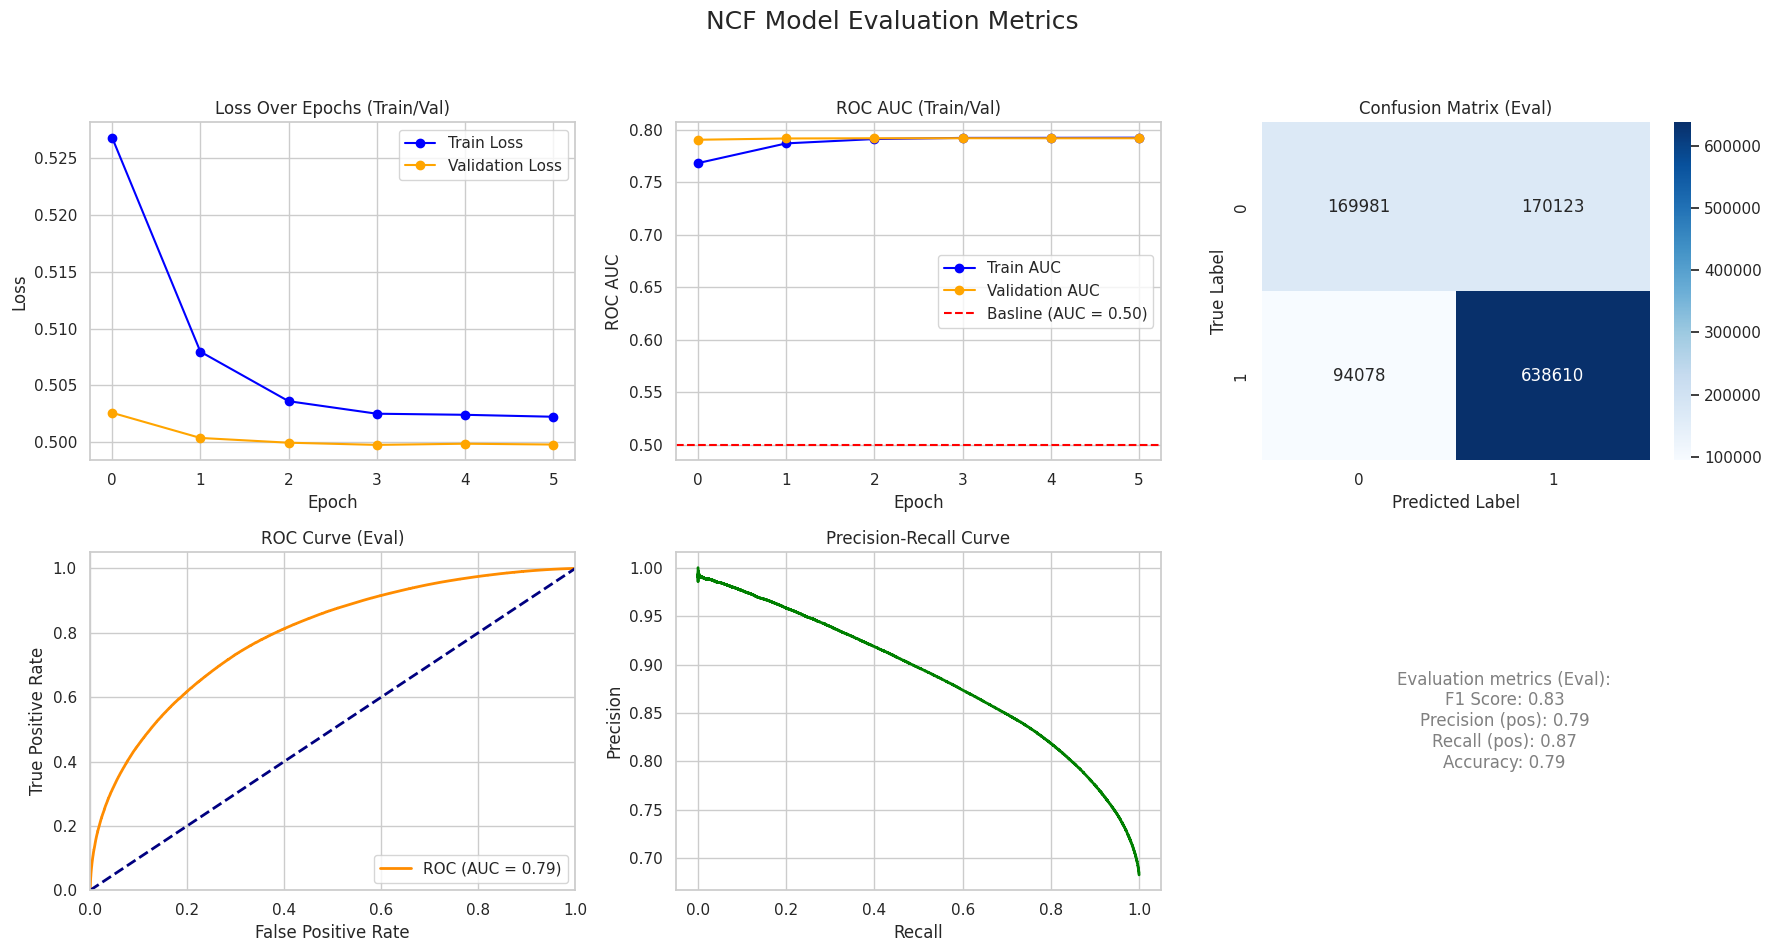

In [ ]:
# Set a professional style
sns.set_theme(style="whitegrid")

# - best_ncf_model : your trained Neural Collaborative Filtering model.
# - history_ncf    : the History object returned by model.fit() for the NCF model.
# - X_user_eval, X_item_eval : evaluation input arrays for users and items.
# - y_eval         : true labels for the evaluation set.

# -------------------
# 1) Predictions & Data Preparation
# -------------------
y_pred_probs_ncf = model.predict([X_user_eval, X_item_eval]).ravel()
y_pred_classes_ncf = (y_pred_probs_ncf > 0.5).astype("int32")

# For a random classifier, the AUC is typically 0.5:
baseline_auc_ncf = 0.5
print(f"Baseline AUC (Random Classifier): {baseline_auc_ncf:.4f}")

# Compute the baseline accuracy (No Information Rate)
baseline_accuracy = max(np.mean(y_eval == 0), np.mean(y_eval == 1))
print(f"No Information Rate (baseline accuracy): {baseline_accuracy:.4f}")
# -------------------
# 2) Evaluate the Model on Training and Evaluation Data
# -------------------
train_loss, train_accuracy = model.evaluate([X_user_train, X_item_train], y_train, verbose=2)
print(f"Final Training Accuracy: {train_accuracy:.4f}")

# -------------------
# 3) Plot Evaluation Metrics
# -------------------
plot_evaluation_metrics_ncf(history_ncf, y_eval, y_pred_probs_ncf, y_pred_classes_ncf, baseline_auc_ncf)

#### Predictions for Competition

Similar to the basic models, we generate test set predictions in the required competition format ([DSG17 Online Phase competition page][1]).

[1]: https://kaggle.com/competitions/dsg17-online-phase "DSG17 Online Phase, 2017. Kaggle."


In [ ]:
# Generate predictions for text set without target variable
X_user_test = unified_test['user_id'].values
X_item_test = unified_test['media_id'].values
predictions = model.predict([X_user_test, X_item_test])
print(f"Test Predictions (first 2): \n {predictions[:2]}")

623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test Predictions (first 2): 
 [[0.53641975]
 [0.68907344]]


---
### Neural Matrix Factorization (NeuMF) Model

We process the unified training data using `further_process_neural_cf` (sample_frac=1.0) and perform a **random split** (70% train, 15% validation, 15% evaluation) with a fixed random state—exactly as with the NCF model.




In [ ]:
# --- NeuMF Preprocessing and Model Loading ---

# (You can adjust sample_frac as needed; here we use 1.0 to use all data)
neumf_df = further_process_neural_cf(unified_train, sample_frac=1.0)
print("NeuMF data shape:", neumf_df.shape)
print(neumf_df.head())

# Split the processed data into train (70%), validation (15%), and evaluation (15%) sets.
train_df, temp_df = train_test_split(neumf_df, test_size=0.3, random_state=42)
val_df, eval_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Evaluation shape:", eval_df.shape)

# Determine the number of unique users and items (needed for the embedding layers).
num_users = neumf_df['user_id'].nunique()
num_items = neumf_df['media_id'].nunique()
print("Number of users:", num_users)
print("Number of items:", num_items)

# Prepare the input arrays for the NeuMF model.
X_user_train = train_df['user_id'].values
X_item_train = train_df['media_id'].values
y_train = train_df['target'].values

X_user_val = val_df['user_id'].values
X_item_val = val_df['media_id'].values
y_val = val_df['target'].values

X_user_eval = eval_df['user_id'].values
X_item_eval = eval_df['media_id'].values
y_eval = eval_df['target'].values

NeuMF data shape: (7151946, 4)
   user_id  media_id  target  behavior_index
0     9241       479       0        0.055630
1    16547      1483       1        0.117163
2     7665      2595       1        0.040773
3     1580     17408       0        0.735870
4     1812      4228       1        2.226328
Train shape: (5006362, 4)
Validation shape: (1072792, 4)
Evaluation shape: (1072792, 4)
Number of users: 19899
Number of items: 386300


---

#### Training and Tuning with Keras Tuner Random Search NeuMF

We instantiate a Keras Tuner using **RandomSearch** with **EarlyStopping** to optimize our NeuMF model. The tuner explores hyperparameters—including GMF and MLP embedding dimensions, number of MLP layers, dense layer units and L2 regularization factors, dropout rate, and learning rate—to maximize validation AUC. After 5 trials, the best configuration was identified (e.g., `{'gmf_embedding_dim': 16, 'mlp_embedding_dim': 24, 'num_mlp_layers': 1, 'dropout_rate': 0.2, 'mlp_units_0': 64, 'mlp_reg_0': 0.0001009, 'mlp_units_1': 112, 'mlp_reg_1': 0.0006370, 'learning_rate': 0.0001}`), achieving a **validation AUC** of approximately **0.80**. We then build, summarize, and train this optimal model for up to 20 epochs with early stopping, and persist the tuner directory for future reference.



In [ ]:
# !rm -rf neumf_tuner_dir # to train again

In [ ]:
# Instantiate Keras Tuner (using RandomSearch with EarlyStopping).
tuner_neumf = kt.RandomSearch(
    hypermodel=lambda hp: build_neumf_model_with_hp(hp, num_users=num_users, num_items=num_items),
    objective=kt.Objective('val_auc', direction='max'),
    max_trials=5,
    executions_per_trial=1,
    directory='neumf_tuner_dir',
    project_name='neumf_project'
)

tuner_neumf.search([X_user_train, X_item_train], y_train, epochs=5,
                   validation_data=([X_user_val, X_item_val], y_val),
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])

best_hps_neumf = tuner_neumf.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters for NeuMF:")
print(best_hps_neumf.values)

# Build and summarize the best NeuMF model.
best_neumf_model = tuner_neumf.hypermodel.build(best_hps_neumf)
best_neumf_model.summary()

# Then you can train the model as usual:
history_neumf = best_neumf_model.fit([X_user_train, X_item_train], y_train, epochs=20,
                                     batch_size=256,
                                     validation_data=([X_user_val, X_item_val], y_val),
                                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])
# safe it for later
!cp -r neumf_tuner_dir /content/drive/MyDrive/

Trial 5 Complete [00h 56m 28s]
val_auc: 0.7968763113021851

Best val_auc So Far: 0.8014428615570068
Total elapsed time: 05h 05m 15s
Best hyperparameters for NeuMF:
{'gmf_embedding_dim': 16, 'mlp_embedding_dim': 24, 'num_mlp_layers': 1, 'dropout_rate': 0.2, 'mlp_units_0': 64, 'mlp_reg_0': 0.00010091713987401433, 'mlp_units_1': 112, 'mlp_reg_1': 0.000637042898847534, 'learning_rate': 0.0001}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlp_user_embedding        │ (None, 1, 24)          │        477,576 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlp_item_embedding        │ (None, 1, 24)          │      9,271,200 │ item_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlp_user_flat (Flatten)   │ (None, 24)             │              0 │ mlp_user_embedding[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlp_item_flat (Flatten)   │ (None, 24)             │              0 │ mlp_item_embedding[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlp_concat (Concatenate)  │ (None, 48)             │              0 │ mlp_user_flat[0][0],   │
│                           │                        │                │ mlp_item_flat[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gmf_user_embedding        │ (None, 1, 16)          │        318,384 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gmf_item_embedding        │ (None, 1, 16)          │      6,180,800 │ item_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlp_dense_0 (Dense)       │ (None, 64)             │          3,136 │ mlp_concat[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gmf_user_flat (Flatten)   │ (None, 16)             │              0 │ gmf_user_embedding[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gmf_item_flat (Flatten)   │ (None, 16)             │              0 │ gmf_item_embedding[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_0 (BatchNormalization) │ (None, 64)             │            256 │ mlp_dense_0[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gmf_multiply (Multiply)   │ (None, 16)             │              0 │ gmf_user_flat[0][0],   │
│                           │                        │                │ gmf_item_flat[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlp_dropout_0 (Dropout)   │ (None, 64)             │              0 │ bn_0[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ neumf_concat              │ (None, 80)             │              0 │ gmf_multiply[0][0],    │
│ (Concatenate)             │                        │                │ mlp_dropout_0[0][0]    │
├──────────────────────

 Total params: 16,251,433 (61.99 MB)

 Trainable params: 16,251,305 (61.99 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/20
19557/19557 ━━━━━━━━━━━━━━━━━━━━ 104s 5ms/step - auc: 0.7545 - loss: 0.5349 - val_auc: 0.7950 - val_loss: 0.4983
Epoch 2/20
19557/19557 ━━━━━━━━━━━━━━━━━━━━ 97s 5ms/step - auc: 0.8101 - loss: 0.4840 - val_auc: 0.8010 - val_loss: 0.4931
Epoch 3/20
19557/19557 ━━━━━━━━━━━━━━━━━━━━ 97s 5ms/step - auc: 0.8336 - loss: 0.4595 - val_auc: 0.8012 - val_loss: 0.4940
Epoch 4/20
19557/19557 ━━━━━━━━━━━━━━━━━━━━ 97s 5ms/step - auc: 0.8515 - loss: 0.4381 - val_auc: 0.8011 - val_loss: 0.4962


#### Inspecting the Learning Process and Metrics (NeuMF)

After training, we compare NeuMF to a random baseline (AUC = 0.50) and a no-information rate (0.6830). The training loss decreases steadily, while the validation loss plateaus after epoch 1—possibly due to overfitting. Both **validation** and **evaluation ROC AUC** are around **0.80**, surpassing the baselines and slightly outperforming the NCF model. Evaluation metrics indicate an **F1** of **0.83**, **precision** of **0.79**, **recall** of **0.89**, and **accuracy** of **0.80**. The confusion matrix, ROC curve, and Precision-Recall curve confirm solid performance, despite minor discrepancies in accuracy (0.89 vs 0.80) aggregation. Overall, NeuMF’s GMF+MLP structure effectively captures both linear and non-linear user–item interactions.



33525/33525 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step
Baseline AUC (Random Classifier): 0.5000
No Information Rate (baseline accuracy): 0.6830
156449/156449 - 168s - 1ms/step - auc: 0.8378 - loss: 0.4550
Final Training Accuracy: 0.8378
33525/33525 - 36s - 1ms/step - auc: 0.8006 - loss: 0.4936


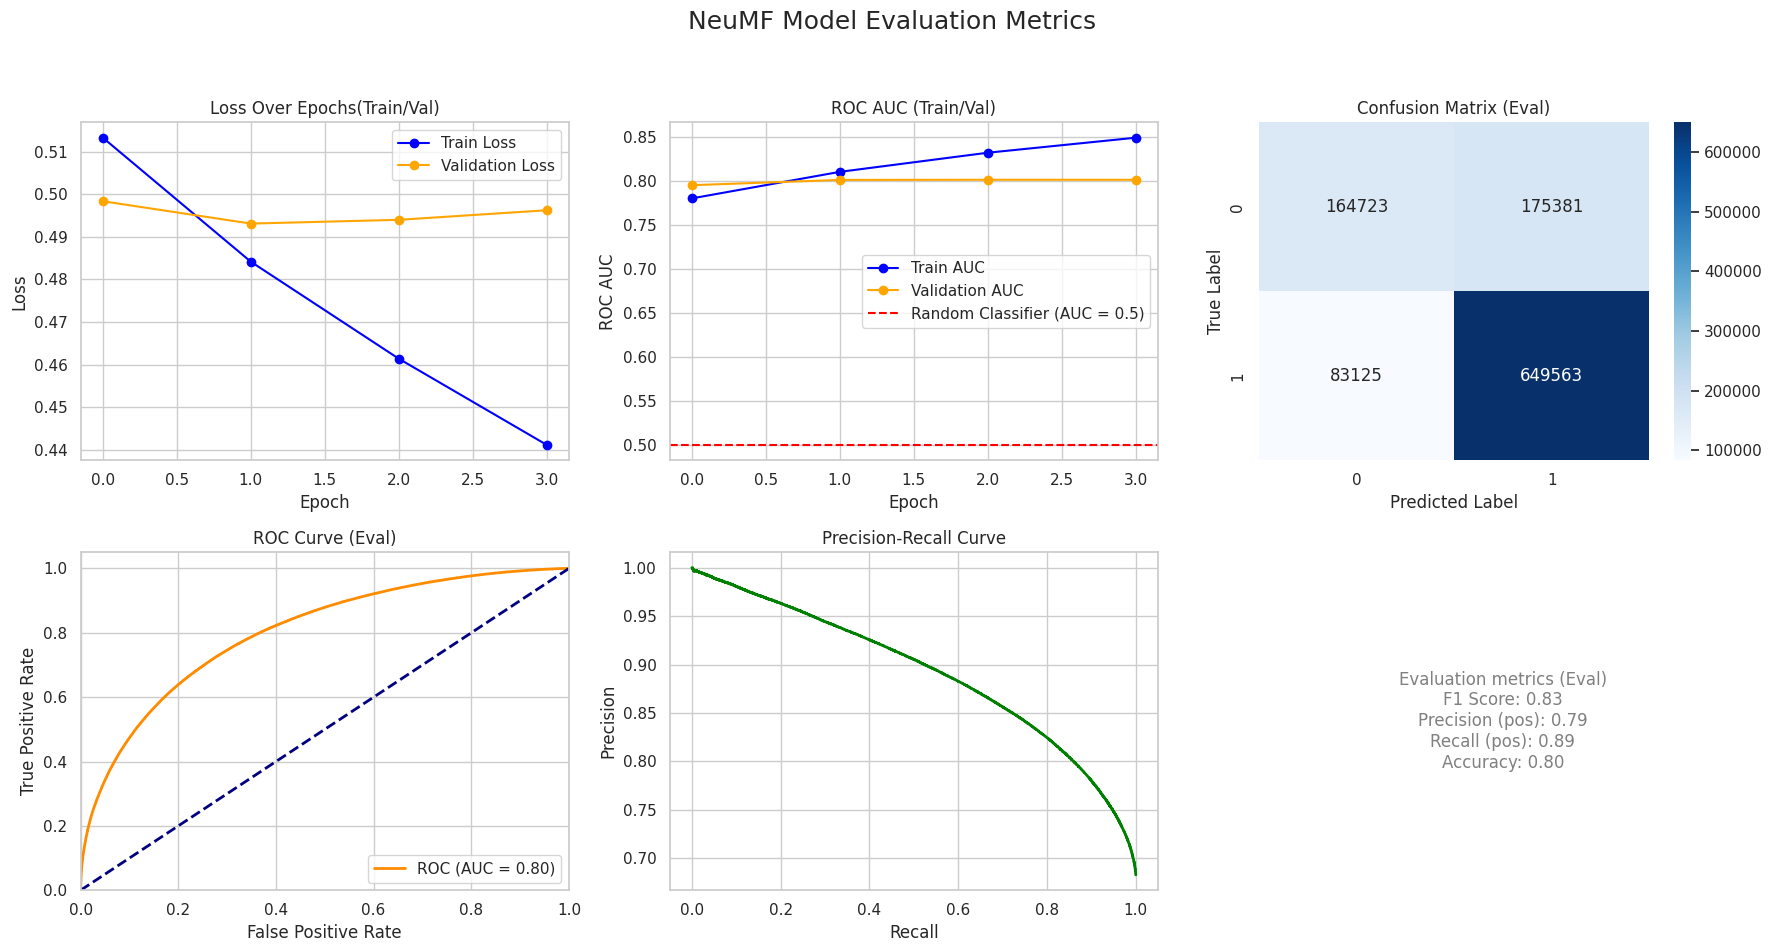

In [ ]:
# Set a professional style
sns.set_theme(style="whitegrid")

# -------------------
# 1) Predictions & Data Preparation
# -------------------
y_pred_probs = best_neumf_model.predict([X_user_eval, X_item_eval]).ravel()
y_pred_classes = (y_pred_probs > 0.5).astype("int32")

# For a random classifier, the AUC is typically 0.5:
baseline_auc_ncf = 0.5
print(f"Baseline AUC (Random Classifier): {baseline_auc_ncf:.4f}")

# Compute the baseline accuracy (No Information Rate)
baseline_accuracy = max(np.mean(y_eval == 0), np.mean(y_eval == 1))
print(f"No Information Rate (baseline accuracy): {baseline_accuracy:.4f}")

# -------------------
# 2) Evaluate the Model on Training and Evaluation Data
# -------------------
train_loss, train_accuracy = best_neumf_model.evaluate([X_user_train, X_item_train], y_train, verbose=2)
print(f"Final Training Accuracy: {train_accuracy:.4f}")

# -------------------
# 3) Plot Evaluation Metrics
# -------------------
plot_evaluation_metrics_neumf(history_neumf, y_eval, y_pred_probs, y_pred_classes, baseline_accuracy)

#### Predictions for Competition

Similar to prior models, we generate test set predictions in the required competition format ([DSG17 Online Phase competition page][1]).

[1]: https://kaggle.com/competitions/dsg17-online-phase "DSG17 Online Phase, 2017. Kaggle."


In [ ]:
# Generate predictions for text set without target variable
X_user_test = unified_test['user_id'].values
X_item_test = unified_test['media_id'].values
predictions = best_neumf_model.predict([X_user_test, X_item_test])
print(f"Test Predictions (first 2): \n {predictions[:2]}")

623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test Predictions (first 2): 
 [[0.78435767]
 [0.6683869 ]]


---
### Graph Sample and Aggregate-based (GraphSAGE) Recommender

In [ ]:
# Install required packages
!pip install keras-tuner
!pip uninstall torch-scatter torch-sparse torch-cluster torch-spline-conv -y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 45.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 63.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 67.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.5/886.5 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.7 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Sat Feb 15 07:39:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import SAGEConv
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


# ---------------------
# 1. Preprocess & Splitting Function (Graph Processor)
# ---------------------
class GraphDataProcessor:
    """
    Prepares the data for our Graph Neural Network recommender.
    This includes:
      - Mapping user_id and media_id to contiguous integers.
      - Optionally subsampling the training dataset.
      - Splitting the training data into train/validation/evaluation sets.
    """
    def __init__(self, train_df: pd.DataFrame, test_df: pd.DataFrame, sample_frac: float = 1.0):
        self.train_df = train_df.copy()
        self.test_df = test_df.copy()
        self.sample_frac = sample_frac

    def process(self):
        # Optionally subsample the training data.
        if self.sample_frac < 1.0:
            self.train_df = self.train_df.sample(frac=self.sample_frac, random_state=42).reset_index(drop=True)
            print(f"Subsampled training data to {self.sample_frac*100:.1f}% of original size.")

        # Create mapping dictionaries based solely on training data.
        train_user_ids = self.train_df['user_id'].unique()
        train_media_ids = self.train_df['media_id'].unique()
        user_mapping = {u: i for i, u in enumerate(train_user_ids)}
        media_mapping = {m: i for i, m in enumerate(train_media_ids)}

        # Map training IDs.
        self.train_df['user_id'] = self.train_df['user_id'].map(user_mapping)
        self.train_df['media_id'] = self.train_df['media_id'].map(media_mapping)

        # Map test IDs; drop rows with unseen users/items.
        self.test_df['user_id'] = self.test_df['user_id'].map(user_mapping)
        self.test_df['media_id'] = self.test_df['media_id'].map(media_mapping)
        self.test_df = self.test_df.dropna(subset=['user_id', 'media_id']).reset_index(drop=True)

        # Ensure IDs are integers.
        self.train_df['user_id'] = self.train_df['user_id'].astype(int)
        self.train_df['media_id'] = self.train_df['media_id'].astype(int)
        self.test_df['user_id'] = self.test_df['user_id'].astype(int)
        self.test_df['media_id'] = self.test_df['media_id'].astype(int)

        self.user_mapping = user_mapping
        self.media_mapping = media_mapping
        return self.train_df, self.test_df

    def prepare_train_val_eval_data(self, split_strategy: str = 'global', val_ratio: float = 0.15, eval_ratio: float = 0.15):
        """
        Splits the training data into training, validation, and evaluation sets.
        If the 'ts_listen' column exists, a global (time‐sorted) split is applied;
        otherwise, a random split is used.
        """
        if 'ts_listen' in self.train_df.columns:
            df = self.train_df.copy()
            df['ts_listen'] = pd.to_datetime(df['ts_listen'])
            if split_strategy == 'global':
                df_sorted = df.sort_values('ts_listen')
                n = len(df_sorted)
                train_end = int(n * (1 - (val_ratio + eval_ratio)))
                val_end = int(n * (1 - eval_ratio))
                train_data = df_sorted.iloc[:train_end].copy()
                val_data = df_sorted.iloc[train_end:val_end].copy()
                eval_data = df_sorted.iloc[val_end:].copy()
            else:
                df_shuffled = df.sample(frac=1, random_state=42)
                n = len(df_shuffled)
                val_size = int(n * val_ratio)
                eval_size = int(n * eval_ratio)
                val_data = df_shuffled.iloc[:val_size].copy()
                eval_data = df_shuffled.iloc[val_size:val_size+eval_size].copy()
                train_data = df_shuffled.iloc[val_size+eval_size:].copy()
        else:
            df_shuffled = self.train_df.sample(frac=1, random_state=42)
            n = len(df_shuffled)
            val_size = int(n * val_ratio)
            eval_size = int(n * eval_ratio)
            val_data = df_shuffled.iloc[:val_size].copy()
            eval_data = df_shuffled.iloc[val_size:val_size+eval_size].copy()
            train_data = df_shuffled.iloc[val_size+eval_size:].copy()
        return train_data, val_data, eval_data

    def compute_class_weights(self, data: pd.DataFrame):
        from sklearn.utils.class_weight import compute_class_weight
        classes = np.unique(data['target'])
        weights = compute_class_weight(class_weight='balanced', classes=classes, y=data['target'])
        return {cls: weight for cls, weight in zip(classes, weights)}

# ---------------------
# 2. Build Edge Index Function
# ---------------------
def build_edge_index(df: pd.DataFrame, num_users: int):
    """
    Constructs an undirected edge index from positive interactions.
    Item indices are shifted by num_users so that users and items have separate ranges.
    """
    pos_df = df[df['target'] == 1]
    user_indices = pos_df['user_id'].values
    item_indices = pos_df['media_id'].values
    item_indices_shifted = item_indices + num_users  # Shift items.

    # Create undirected edges.
    src = np.concatenate([user_indices, item_indices_shifted])
    dst = np.concatenate([item_indices_shifted, user_indices])
    edge_index = torch.tensor(np.array([src, dst]), dtype=torch.long)
    return edge_index

# ---------------------
# 3. Define the GraphSAGE Model and Prediction Function
# ---------------------
class GraphSAGERecommender(nn.Module):
    def __init__(self, num_nodes: int, embedding_dim: int, num_layers: int = 2):
        """
        num_nodes: Total nodes = num_users + num_items.
        embedding_dim: Dimension of node embeddings.
        num_layers: Number of GraphSAGE (SAGEConv) layers.
        """
        super(GraphSAGERecommender, self).__init__()
        self.embedding = nn.Embedding(num_nodes, embedding_dim)
        nn.init.xavier_uniform_(self.embedding.weight)

        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(embedding_dim, embedding_dim))
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(embedding_dim, embedding_dim))

    def forward(self, edge_index):
        x = self.embedding.weight  # Initial embeddings.
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
        return x

def predict_score(user_emb: torch.Tensor, item_emb: torch.Tensor) -> torch.Tensor:
    """
    Computes a prediction score using the dot product between user and item embeddings,
    followed by a sigmoid activation.
    """
    logits = (user_emb * item_emb).sum(dim=1)
    return torch.sigmoid(logits)

# ---------------------
# 4. Plotting Function for Evaluation Metrics
# ---------------------
def plot_evaluation_metrics(train_losses, val_losses, val_aucs, y_eval, y_pred_probs, y_pred_classes, baseline_accuracy):
    """
    Create a 2x3 grid of evaluation plots including:
      - Plot A: Training and Validation Loss over epochs (from training/validation sets)
      - Plot B: Validation ROC AUC over epochs (with baseline)
      - Plot C: Confusion Matrix (Evaluation set)
      - Plot D: ROC Curve (Evaluation set)
      - Plot E: Precision-Recall Curve (Evaluation set)
      - Plot F: A summary of additional metrics (Evaluation set)

    Parameters:
      train_losses: List of training losses per epoch.
      val_losses: List of validation losses per epoch.
      val_aucs: List of validation ROC AUC scores per epoch.
      y_eval: True labels for the evaluation set.
      y_pred_probs: Continuous prediction probabilities for the evaluation set.
      y_pred_classes: Binary predictions for the evaluation set.
      baseline_accuracy: The no-information rate (baseline accuracy).
    """
    sns.set_theme(style="whitegrid")

    # Compute additional metrics on the evaluation set.
    roc_fpr, roc_tpr, _ = roc_curve(y_eval, y_pred_probs)
    roc_auc_val = auc(roc_fpr, roc_tpr)
    precision, recall, _ = precision_recall_curve(y_eval, y_pred_probs)
    f1 = f1_score(y_eval, y_pred_classes)

    # Compute classification report.
    report = classification_report(y_eval, y_pred_classes, output_dict=True)

    # Integrate precision and recall as shown before.
    if '1' in report:
        precision_pos = report['1']['precision']
        recall_pos = report['1']['recall']
    else:
        precision_pos = 0.0
        recall_pos = 0.0

    # Create subplots.
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    fig.suptitle("Model Evaluation Metrics", fontsize=18)

    # Plot A: Loss Over Epochs (Training and Validation).
    axes[0, 0].plot(train_losses, label='Train Loss', marker='o', color='blue')
    axes[0, 0].plot(val_losses, label='Validation Loss', marker='o', color='orange')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Loss Over Epochs (Train/Val)')
    axes[0, 0].legend()

    # Plot B: Validation ROC AUC Over Epochs with Baseline.
    axes[0, 1].plot(val_aucs, label='Validation ROC AUC', marker='o', color='blue')
    axes[0, 1].axhline(y=baseline_accuracy, color='red', linestyle='--', label=f'Baseline ({baseline_accuracy:.2f})')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('ROC AUC')
    axes[0, 1].set_title('Validation ROC AUC')
    axes[0, 1].legend()

    # Plot C: Confusion Matrix (Evaluation set).
    cm = confusion_matrix(y_eval, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 2])
    axes[0, 2].set_xlabel('Predicted Label')
    axes[0, 2].set_ylabel('True Label')
    axes[0, 2].set_title('Confusion Matrix (Eval)')

    # Plot D: ROC Curve (Evaluation set).
    axes[1, 0].plot(roc_fpr, roc_tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc_val:.2f})')
    axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].set_title('ROC Curve (Eval)')
    axes[1, 0].legend(loc='lower right')

    # Plot E: Precision-Recall Curve (Evaluation set).
    axes[1, 1].plot(recall, precision, color='green', lw=2)
    axes[1, 1].set_xlabel('Recall')
    axes[1, 1].set_ylabel('Precision')
    axes[1, 1].set_title('Precision-Recall Curve (Eval)')

    # Plot F: Metrics Summary.
    summary_text = (f"F1 Score: {f1:.2f}\n"
                    f"Precision (pos): {precision_pos:.2f}\n"
                    f"Recall (pos): {recall_pos:.2f}\n"
                    f"Accuracy: {np.mean(y_eval == y_pred_classes):.2f}")
    axes[1, 2].text(0.5, 0.5, summary_text, horizontalalignment='center',
                    verticalalignment='center', fontsize=12, color='gray', transform=axes[1, 2].transAxes)
    axes[1, 2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
# ---------------------
# 5. Evaluation Function
# ---------------------
def evaluate_graph_model(model: nn.Module, edge_index: torch.Tensor, user_tensor: torch.Tensor,
                         item_tensor: torch.Tensor, num_users: int, device: torch.device) -> np.ndarray:
    """
    Evaluates the GraphSAGE model by computing predictions for the given users and items.
    """
    model.eval()
    with torch.no_grad():
        all_embeddings = model(edge_index)
        user_emb = all_embeddings[user_tensor]
        item_emb = all_embeddings[item_tensor + num_users]  # Shift item indices.
        preds = predict_score(user_emb, item_emb)
    return preds.cpu().numpy()

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

Below we load the unified training and test data from CSV files and instantiate a **GraphDataProcessor** with `sample_frac=1.0`. As in our MF and Group 1 models, we perform a **global** (time-sorted) split—dividing the data into 70% training, 15% validation, and 15% evaluation. The processor maps `user_id` and `media_id` to contiguous integers, computes class weights, and determines unique user and item counts. An **edge index** is built from positive interactions, and tensors for training and validation are prepared.

In [ ]:
# ---------------------
# 5. Main Pipeline Execution
# ---------------------
# Update file paths as needed.
train_path = "/content/drive/MyDrive/Colab Notebooks/processed_deezer_train.csv"
test_path  = "/content/drive/MyDrive/Colab Notebooks/processed_deezer_test.csv"

# Load data
unified_train = pd.read_csv(train_path)
unified_test  = pd.read_csv(test_path)

# Instantiate the processor with a subsample fraction (e.g., I used small samples for trying things out)
processor = GraphDataProcessor(train_df=unified_train, test_df=unified_test, sample_frac=1.0)
proc_train, proc_test = processor.process()

# Prepare train/validation/evaluation splits.
train_data, val_data, eval_data = processor.prepare_train_val_eval_data(split_strategy='global',
                                                                        val_ratio=0.15, eval_ratio=0.15)
print("Split Dimensions:")
print("Train:", train_data.shape)
print("Validation:", val_data.shape)
print("Evaluation:", eval_data.shape)

# Compute class weights (if needed).
class_weights = processor.compute_class_weights(train_data)
print("\nClass Weights:", class_weights)

# Determine number of users and items.
num_users = len(processor.user_mapping)
num_items = len(processor.media_mapping)
print(f"\nNumber of Users: {num_users}, Number of Items: {num_items}")

# Build the edge index using only the training split.
edge_index_train = build_edge_index(train_data, num_users)

# ---------------------
# 6. Prepare Data for Training & Validation
# ---------------------
# We use only positive interactions for training/validation and evaluation.
train_pos = train_data[train_data['target'] == 1]
val_pos   = val_data[val_data['target'] == 1]

train_users = torch.tensor(train_pos['user_id'].values, dtype=torch.long)
train_items = torch.tensor(train_pos['media_id'].values, dtype=torch.long)
val_users   = torch.tensor(val_pos['user_id'].values, dtype=torch.long)
val_items   = torch.tensor(val_pos['media_id'].values, dtype=torch.long)

Split Dimensions:
Train: (5006362, 44)
Validation: (1072792, 44)
Evaluation: (1072792, 44)

Class Weights: {0: 1.6197048765573892, 1: 0.7232731188673952}

Number of Users: 19899, Number of Items: 386300


#### Training GraphSAGE

We select CUDA and move our tensors (edge_index, train_users, train_items, val_users, and val_items) to the device. With 19,899 users and 386,300 items, we instantiate the **GraphSAGERecommender** with `num_nodes = num_users + num_items`, an **embedding dimension** of **64**, and **2 SAGEConv layers**. Training uses Adam and binary cross-entropy loss with **negative sampling** in mini-batches of 1024 over 10 epochs. Each epoch, we randomly permute the training data, sample a negative item per positive interaction, and update the model. **Training AUC improves** from **0.962 to 0.982**, while **validation AUC** stabilizes around **0.886**.



In [ ]:
# ---------------------
# 7. Set up Device, Instantiate Model, and Train
# ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nUsing device:", device)
edge_index_train = edge_index_train.to(device)
train_users = train_users.to(device)
train_items = train_items.to(device)
val_users   = val_users.to(device)
val_items   = val_items.to(device)

model = GraphSAGERecommender(num_nodes=num_users + num_items, embedding_dim=64, num_layers=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
bce_loss = nn.BCELoss()

batch_size = 1024
num_epochs = 10

train_losses = []
val_losses = []
val_aucs = []

for epoch in range(num_epochs):
    model.train()
    permutation = torch.randperm(len(train_users))
    epoch_loss = 0.0

    # Mini-batch training with negative sampling.
    for i in range(0, len(train_users), batch_size):
        indices = permutation[i: i + batch_size]
        batch_users = train_users[indices]
        batch_pos_items = train_items[indices]
        # For each positive interaction, sample one negative item.
        batch_neg_items = torch.randint(0, num_items, (len(indices),), dtype=torch.long).to(device)

        optimizer.zero_grad()
        all_embeddings = model(edge_index_train)
        user_emb = all_embeddings[batch_users]
        pos_item_emb = all_embeddings[batch_pos_items + num_users]
        neg_item_emb = all_embeddings[batch_neg_items + num_users]

        pos_preds = predict_score(user_emb, pos_item_emb)
        neg_preds = predict_score(user_emb, neg_item_emb)

        pos_labels = torch.ones_like(pos_preds)
        neg_labels = torch.zeros_like(neg_preds)

        loss = bce_loss(pos_preds, pos_labels) + bce_loss(neg_preds, neg_labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / ((len(train_users) // batch_size) + 1)
    train_losses.append(avg_train_loss)

    # ---- Compute Training AUC ----
    model.eval()
    with torch.no_grad():
        all_embeddings = model(edge_index_train)
        train_user_emb = all_embeddings[train_users]
        train_item_emb = all_embeddings[train_items + num_users]
        train_preds = predict_score(train_user_emb, train_item_emb)
        # Negative sampling for training evaluation.
        neg_train_items = torch.randint(0, num_items, (len(train_users),), dtype=torch.long).to(device)
        neg_train_item_emb = all_embeddings[neg_train_items + num_users]
        neg_train_preds = predict_score(train_user_emb, neg_train_item_emb)

        all_train_preds = torch.cat([train_preds, neg_train_preds]).cpu().numpy()
        all_train_labels = np.concatenate([np.ones(len(train_preds)), np.zeros(len(neg_train_preds))])
        train_auc = roc_auc_score(all_train_labels, all_train_preds)

    # ---- Validation Evaluation ----
    with torch.no_grad():
        all_embeddings = model(edge_index_train)
        val_user_emb = all_embeddings[val_users]
        val_item_emb = all_embeddings[val_items + num_users]
        val_preds = predict_score(val_user_emb, val_item_emb)
        # Negative sampling for validation.
        neg_val_items = torch.randint(0, num_items, (len(val_users),), dtype=torch.long).to(device)
        neg_val_item_emb = all_embeddings[neg_val_items + num_users]
        neg_val_preds = predict_score(val_user_emb, neg_val_item_emb)

        all_val_preds = torch.cat([val_preds, neg_val_preds]).cpu().numpy()
        all_val_labels = np.concatenate([np.ones(len(val_preds)), np.zeros(len(neg_val_preds))])
        val_auc = roc_auc_score(all_val_labels, all_val_preds)

        val_loss = bce_loss(val_preds, torch.ones_like(val_preds)) + bce_loss(neg_val_preds, torch.zeros_like(neg_val_preds))
        val_losses.append(val_loss.item())
        val_aucs.append(val_auc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Train AUC: {train_auc:.4f} | Val Loss: {val_loss.item():.4f} | Val AUC: {val_auc:.4f}")


Using device: cuda
Epoch 1/10 | Train Loss: 0.9445 | Train AUC: 0.9624 | Val Loss: 0.9861 | Val AUC: 0.8819
Epoch 2/10 | Train Loss: 0.8889 | Train AUC: 0.9739 | Val Loss: 0.9759 | Val AUC: 0.8863
Epoch 3/10 | Train Loss: 0.8681 | Train AUC: 0.9764 | Val Loss: 0.9694 | Val AUC: 0.8864
Epoch 4/10 | Train Loss: 0.8561 | Train AUC: 0.9786 | Val Loss: 0.9651 | Val AUC: 0.8864
Epoch 5/10 | Train Loss: 0.8491 | Train AUC: 0.9800 | Val Loss: 0.9634 | Val AUC: 0.8866
Epoch 6/10 | Train Loss: 0.8438 | Train AUC: 0.9809 | Val Loss: 0.9618 | Val AUC: 0.8860
Epoch 7/10 | Train Loss: 0.8396 | Train AUC: 0.9812 | Val Loss: 0.9604 | Val AUC: 0.8854
Epoch 8/10 | Train Loss: 0.8368 | Train AUC: 0.9817 | Val Loss: 0.9588 | Val AUC: 0.8854
Epoch 9/10 | Train Loss: 0.8346 | Train AUC: 0.9821 | Val Loss: 0.9599 | Val AUC: 0.8849
Epoch 10/10 | Train Loss: 0.8329 | Train AUC: 0.9824 | Val Loss: 0.9591 | Val AUC: 0.8849


#### Inspecting the Learning Process and Metrics

We extract positive interactions from the evaluation set and sample an equal number of negatives. Using the learned embeddings, predictions are aggregated and thresholded at 0.5 to yield binary classifications. This threshold affects derived metrics (accuracy, precision, recall, F1) but not threshold-invariant measures like ROC AUC or the Precision-Recall curve. Our evaluation yields an **F1** of **0.77**, **precision** of **0.91**, **recall** of **0.66**, and **accuracy** of **0.80**, with **validation** and **evaluation ROC AUCs** of **0.89** and **0.82**, respectively. Although the model begins to overfit around epoch 7, it remains the **best performer** in terms of **ROC AUC**, confirming that GraphSAGE effectively captures user–item interactions.



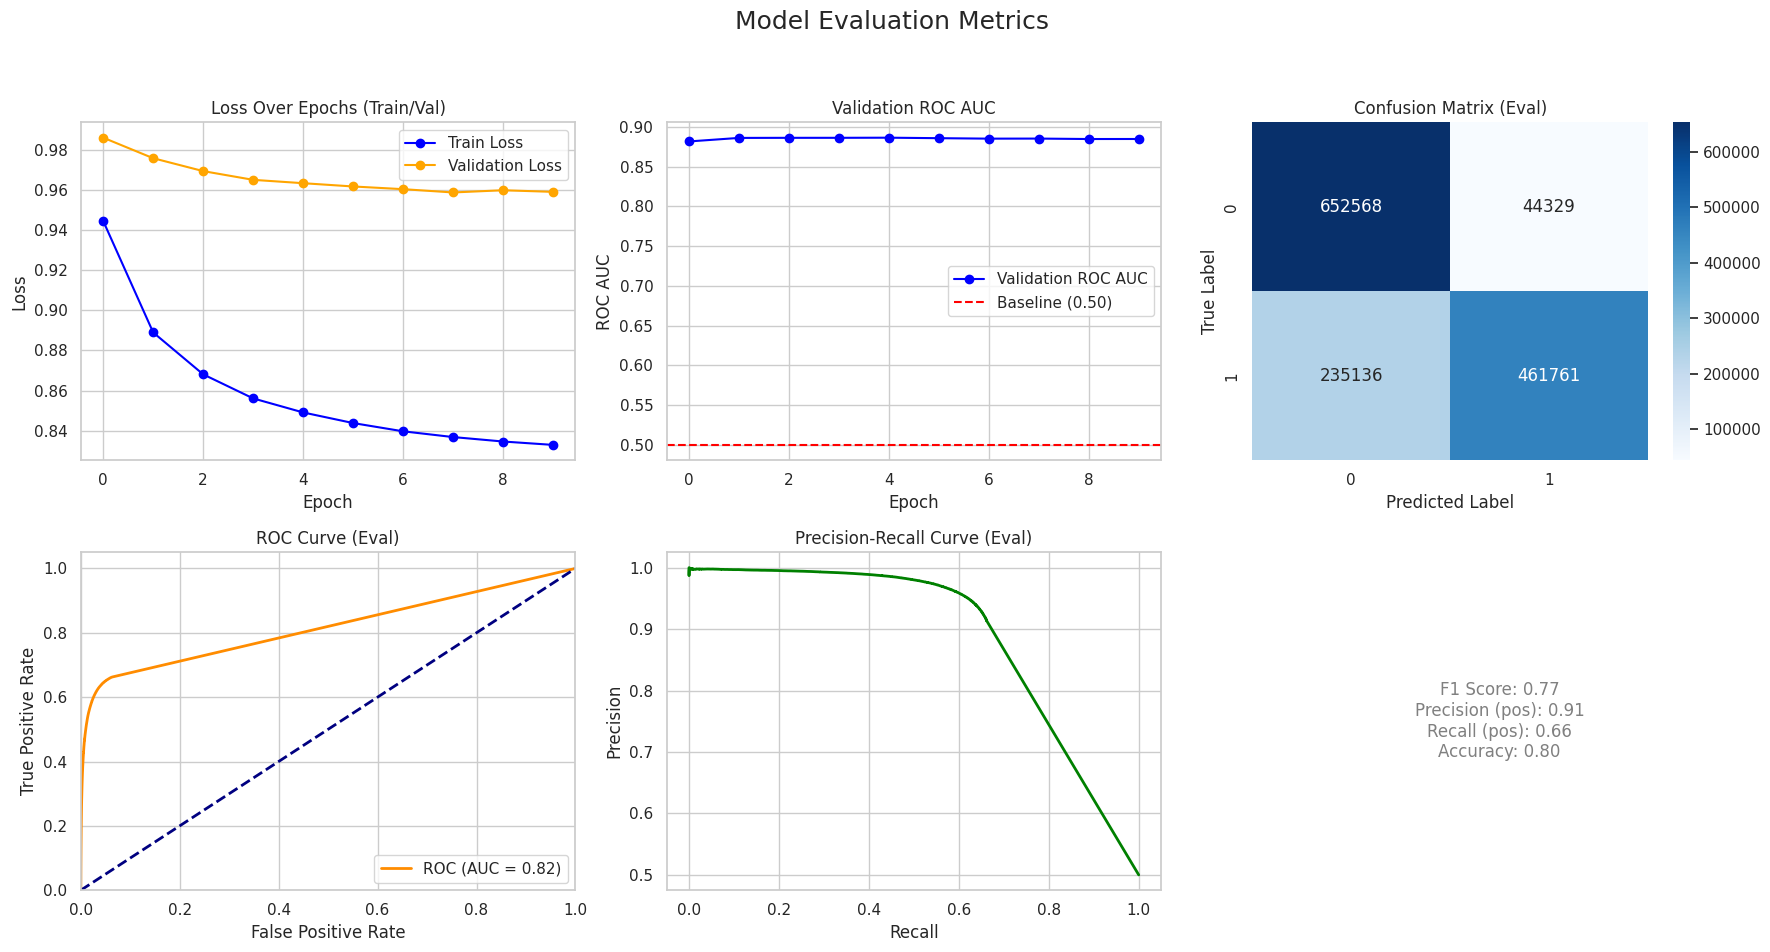

In [ ]:
# Prepare evaluation set tensors (using only positive interactions)
eval_pos = eval_data[eval_data['target'] == 1]
eval_users = torch.tensor(eval_pos['user_id'].values, dtype=torch.long).to(device)
eval_items = torch.tensor(eval_pos['media_id'].values, dtype=torch.long).to(device)

with torch.no_grad():
    all_embeddings = model(edge_index_train)
    eval_user_emb = all_embeddings[eval_users]
    eval_item_emb = all_embeddings[eval_items + num_users]
    eval_preds_pos = predict_score(eval_user_emb, eval_item_emb)

    # Negative sampling for eval: sample as many negatives as positives.
    neg_eval_items = torch.randint(0, num_items, (len(eval_users),), dtype=torch.long).to(device)
    neg_eval_item_emb = all_embeddings[neg_eval_items + num_users]
    eval_preds_neg = predict_score(eval_user_emb, neg_eval_item_emb)

    # Combine positive and negative predictions and labels.
    all_eval_preds = torch.cat([eval_preds_pos, eval_preds_neg]).cpu().numpy()
    all_eval_labels = np.concatenate([np.ones(len(eval_preds_pos)), np.zeros(len(eval_preds_neg))])
    # Now compute binary predictions using the same all_eval_preds.

all_eval_pred_classes = (all_eval_preds > 0.5).astype(int)
y_eval = all_eval_labels.astype(int)
baseline_accuracy = max(np.mean(y_eval == 0), np.mean(y_eval == 1))

plot_evaluation_metrics(train_losses, val_losses, val_aucs,
                        y_eval, all_eval_preds, all_eval_pred_classes,
                        baseline_accuracy)

#### Predictions for Competition

Similar to prior models, we generate test set predictions in the required competition format ([DSG17 Online Phase competition page][1]).

[1]: https://kaggle.com/competitions/dsg17-online-phase "DSG17 Online Phase, 2017. Kaggle."

In [ ]:
# ---------------------
# 9. Final Inference & Inspect Predictions
# ---------------------
model.eval()
with torch.no_grad():
    # Compute final node embeddings using the training graph.
    final_embeddings = model(edge_index_train)
    user_embeddings = final_embeddings[:num_users]
    item_embeddings = final_embeddings[num_users:]

    # Prepare test set tensors.
    test_users = torch.tensor(proc_test['user_id'].values, dtype=torch.long).to(device)
    test_items = torch.tensor(proc_test['media_id'].values, dtype=torch.long).to(device)

    test_user_emb = user_embeddings[test_users]
    test_item_emb = item_embeddings[test_items]
    test_preds = predict_score(test_user_emb, test_item_emb)

    # Create a DataFrame of predictions.
    pred_df = pd.DataFrame({
        "sample_id": proc_test["sample_id"] if "sample_id" in proc_test.columns
                     else np.arange(len(proc_test)),
        "is_listened": test_preds.cpu().numpy().ravel().round(2)
    })

    # Print the first 2 rows in CSV format.
    print("Graph Neural Net test predictions (first 2 rows):")
    print(pred_df.iloc[0:,1].head(2).to_csv(index=False))

Graph Neural Net test predictions (first 2 rows):
is_listened
0.99
1.0



### Summary of Advanced Models

Below is a concise summary of each advanced model’s performance, key hyperparameters, and evaluation metrics. The deep learning–based models (NCF and NeuMF) achieve **evaluation ROC AUCs** around **0.79–0.80**, while GraphSAGE shows a robust **evalutaion ROC AUC** of **~0.82**. In contrast, the **FM** Recommender lags with an evaluation **ROC AUC** of **~0.58**, highlighting the benefits of more complex architectures for capturing user–item interactions.

| **Model**                             | **Validation ROC AUC** | **Evaluation ROC AUC** | **Key Hyperparameters**                                                 | **Evaluation Metrics**                                     |
|:--------------------------------------|:----------------------:|:----------------------:|:------------------------------------------------------------------------|:-----------------------------------------------------------|
| **Factorization Machine (FM)**        | ~0.63                | ~0.58                | `rank=30, n_iter=150, l2_reg_w=0.1, l2_reg_V=0.01`                      | N/A                                                        |
| **Neural Collaborative Filtering (NCF)** | ~0.79               | ~0.79                 | `embedding_dim=16, fc_units=32, dropout_rate=0.4`   | **F1**: 0.83, **Precision**: 0.79, **Recall**: 0.87, **Accuracy**: 0.79 |
| **Neural Matrix Factorization (NeuMF)** | ~0.80               | ~0.80                 | `gmf_embedding_dim=16, mlp_embedding_dim=24, num_mlp_layers=1, dropout_rate=0.2` | **F1**: 0.83, **Precision**: 0.79, **Recall**: 0.89, **Accuracy**: 0.80 |
| **GraphSAGE Recommender**            | ~0.89                | ~0.82                  | `embedding_dim=64, num_layers=2`                                        | **F1**: 0.77, **Precision**: 0.91, **Recall**: 0.66, **Accuracy**: 0.80 |

These results underscore that while FM is less effective in our setup, the deep learning models and GraphSAGE offer substantially better performance. In particular, **GraphSAGE** attains a high **evaluation ROC AUC** (**~0.89**) and solid evaluation metrics, confirming its ability to capture complex user–item interactions. However, each of these methods could benefit from additional hyperparameter tuning, further feature engineering (we still have many variables to explore in the feature store), or architectural refinements—which were not fully explored here due to time constraints and limited resources.